# Load Station Status Stream Files

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime
import math

import seaborn as sns
sns.set()

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25

## Import Data

In [4]:
def load_status_data():

    print('Loading Status Data...')
    file_path_slug = '../streamed_data/*/*station_status*.csv'

    # glob all files
    file_list = glob(file_path_slug)

    status_import = pd.DataFrame()
    chunks = []
    counter = 0

    # load data from each file
    for file in file_list:

        # import file in chunks
        chunk = pd.read_csv(file)

        # add program id to chunk
        chunk['program_id'] = str(file).split('/')[2]

        # append chunk to chunks list
        chunks.append(chunk)

        counter += 1
        if counter == 1 or counter % math.ceil(len(file_list)/10) == 0 or counter == len(file_list):
            print('\tFinished file! (%d of %d)' % (counter, len(file_list)))        

    status_import = pd.concat(chunks)
    print('Data Loaded Successfully!\n')

    program_list = sorted(pd.unique(status_import.program_id))
    print('Started cleaning (%s programs to clean)...' % len(program_list))
    status_import.rename(columns={'last_reported' : 'time',
                                     'eightd_has_available_keys' : 'has_available_keys',
                                     'is_installed' : 'is_installed',
                                     'is_renting' : 'is_renting',
                                     'is_returning' : 'is_returning',
                                     'num_bikes_available' : 'bikes_available',
                                     'num_bikes_disabled' : 'bikes_disabled',
                                     'num_docks_available' : 'docks_available',
                                     'num_docks_disabled' : 'docks_disabled',
                                     'station_id' : 'station_id'}, inplace=True)

    drop_cols = ['eightd_active_station_services', 'has_available_keys', 'is_installed', 'is_renting', 'is_returning', 'bikes_disabled', 'docks_disabled']

    for c in drop_cols:
        try:
            status_import.drop(c, axis=1, inplace=True)
        except:
            pass

    # convert time to datetime, and prune entries pre 2000, some epoch dates are being reported
    status_import['time'] = pd.to_datetime(status_import['time'], format="%Y-%m-%d %H:%M:%S")
    change_date = pd.Timestamp('2017-11-13 00:00')
    status_import = status_import[status_import.time >= change_date]

    status_import.sort_values(['program_id', 'station_id', 'time'], inplace=True)
    
    A = len(status_import)
    status_import.drop_duplicates(subset=['time', 'program_id', 'station_id'], inplace=True)
    B = len(status_import)
    print('\t\tDropped %s duplicates!' % (A-B))
    
    # by program and station ,append dock change and bike change
    cleaned_df = pd.DataFrame()
    cleaned_list = []
    counter = 1
    for pid in program_list:

        df_temp_program = status_import[status_import.program_id == pid].copy()

        # for each dock
        print('%s\t%s - %s Stations to Clean...' % (str(counter).rjust(3), pid.ljust(25), str(len(pd.unique(df_temp_program.station_id))).rjust(4)))
        for sid in pd.unique(df_temp_program.station_id):
            df_temp_station = df_temp_program[df_temp_program.station_id == sid].copy()
            
            # drop duplicates
            A = len(df_temp_station)
            df_temp_station.drop_duplicates(subset='time', inplace=True)
            B = len(df_temp_station)
            if A != B:
                print('\t%s\tDropped %s duplicates!' % (sid, (A-B)))
            
            df_temp_station.sort_values(['time'], inplace=True)

            df_temp_station['bike_change'] = df_temp_station['bikes_available'].diff()
            df_temp_station['bike_change'] = df_temp_station['bike_change'].apply(lambda x: 1 if x > 0 else 0)

            df_temp_station['trips_ending'] = df_temp_station['bikes_available'].diff()
            df_temp_station['trips_ending'] = df_temp_station['trips_ending'].apply(lambda x: x if x > 0 else 0)

            df_temp_station['dock_change'] = df_temp_station['docks_available'].diff()
            df_temp_station['dock_change'] = df_temp_station['dock_change'].apply(lambda x: 1 if x > 0 else 0)

            df_temp_station['trips_starting'] = df_temp_station['docks_available'].diff()
            df_temp_station['trips_starting'] = df_temp_station['trips_starting'].apply(lambda x: x if x > 0 else 0)
            
            df_temp_station['net_traffic'] = df_temp_station['trips_starting'] - df_temp_station['trips_ending']

            cleaned_list.append(df_temp_station)

        counter += 1

    print('Merging DataFrame...')
    cleaned_df = pd.concat(cleaned_list)
    cleaned_df.reset_index(inplace=True, drop=True)

    print('Cleaning Complete!')

    return cleaned_df


In [5]:
status_data = load_status_data()

Loading Status Data...
	Finished file! (1 of 960)
	Finished file! (96 of 960)
	Finished file! (192 of 960)
	Finished file! (288 of 960)
	Finished file! (384 of 960)
	Finished file! (480 of 960)
	Finished file! (576 of 960)
	Finished file! (672 of 960)
	Finished file! (768 of 960)
	Finished file! (864 of 960)
	Finished file! (960 of 960)
Data Loaded Successfully!

Started cleaning (60 programs to clean)...
		Dropped 89091 duplicates!
  1	ba                        -  240 Stations to Clean...
  2	bcyclearborbike           -   13 Stations to Clean...
  3	bcycleaustin              -   54 Stations to Clean...
  4	bcycleaventura            -    5 Stations to Clean...
  5	bcyclebattlecreek         -    4 Stations to Clean...
  6	bcycleboulder             -   43 Stations to Clean...
  7	bcyclebroward             -   24 Stations to Clean...
  8	bcyclebublr               -   75 Stations to Clean...
  9	bcyclecatbike             -    2 Stations to Clean...
 10	bcyclecharlotte           -   25 Stat

In [6]:
status_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226136 entries, 0 to 226135
Data columns (total 10 columns):
time               226136 non-null datetime64[ns]
bikes_available    226136 non-null int64
docks_available    226136 non-null int64
program_id         226136 non-null object
station_id         226136 non-null object
bike_change        226136 non-null int64
trips_ending       226136 non-null float64
dock_change        226136 non-null int64
trips_starting     226136 non-null float64
net_traffic        226136 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(4), object(2)
memory usage: 17.3+ MB


In [7]:
status_data[status_data.trips_starting == status_data.trips_starting.max()]
# status_data.iloc[133530:133540,:]

,time,bikes_available,docks_available,program_id,station_id,bike_change,trips_ending,dock_change,trips_starting,net_traffic
183616,2017-11-13 21:53:11,7,47,nyc,445,0,0.0,1,26.0,26.0


In [9]:
def show_station(df, id, x_label = '', y_label = '', title_suffix='', color='b', col='bikes_available'):
    t = df[df.station_id == id]
    t.set_index('time', inplace=True)
    ax = t[col].cumsum().plot(color=color, figsize=(24,3))
    if title_suffix != '':
        title = 'Station %s - %s' % (id, title_suffix)
    elif y_label != '':
        title = 'Station %s - %s' % (id, y_label)
    else:
        title = 'Station %s' % id
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel(x_label, size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
    plt.show()

In [10]:
def plot_hourly_usage(df, title='CoGo', color='r'):
    
    try:
        df.sort_values('time', inplace=True)
        x_ticks = sorted(pd.unique(df.time.dt.hour))
        df_data = df[df.bike_change != 0]
        df_data.reset_index(inplace=True, drop=True)
        df_status_change = df_data.groupby([df_data.time.dt.hour])['station_id'].count()

        plt.subplots(figsize=(24,3))
        ax = sns.barplot(x = df_status_change.index , y = df_status_change, color=color, alpha = 0.25, label=title)
        ax.set_title('Distribution of Trips by Hour', size=TITLE_FONT_SIZE, weight='bold')
        ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
        ax.set_ylabel('Total Trips', size=LABEL_FONT_SIZE, weight='bold')
    #     ax.set_xticks(x_ticks)
        plt.legend()
        plt.show()
    except:
        print('Unable to plot %s' % title)

ba - (2017-11-13 06:38:26 to 2017-11-13 22:10:27)


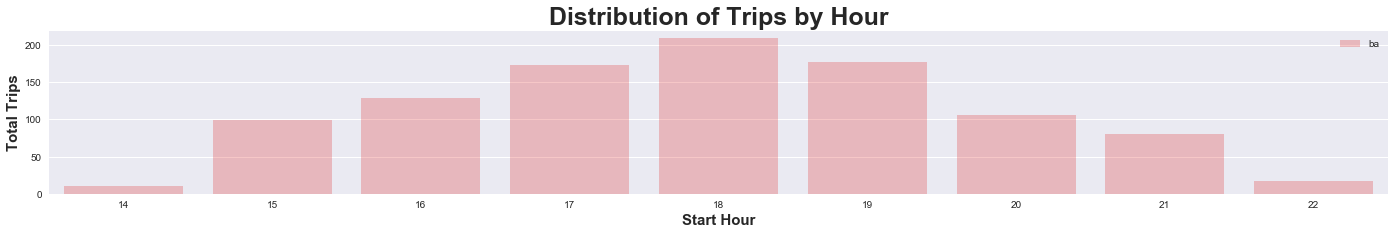

bcyclearborbike - (2017-11-13 17:55:49 to 2017-11-14 01:10:53)


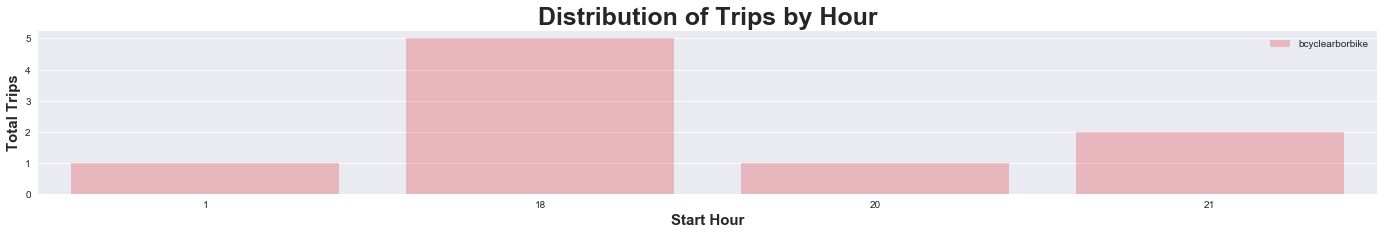

bcycleaustin - (2017-11-13 16:55:18 to 2017-11-14 00:10:27)


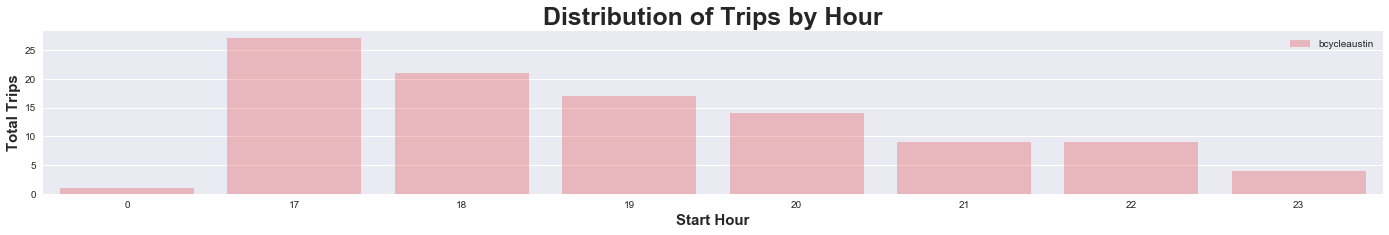

bcycleaventura - (2017-11-13 17:55:50 to 2017-11-14 01:10:53)


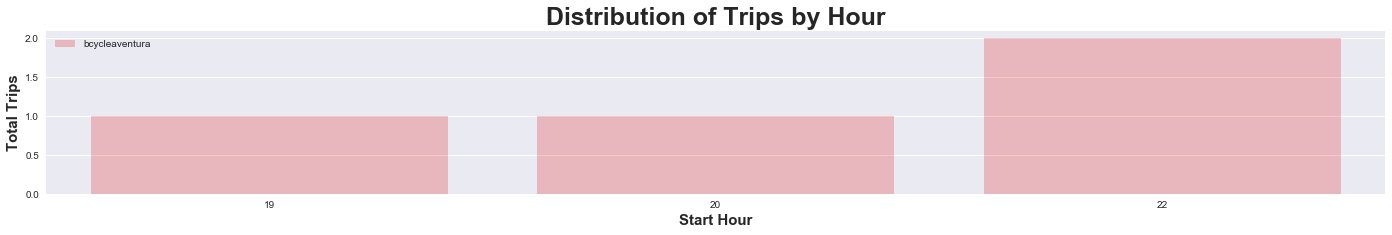

bcyclebattlecreek - (2017-11-13 17:55:51 to 2017-11-14 01:10:54)
Unable to plot bcyclebattlecreek
bcycleboulder - (2017-11-13 15:55:13 to 2017-11-13 23:10:21)


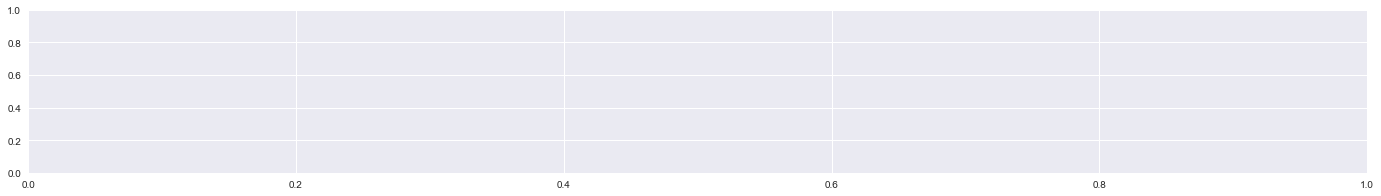

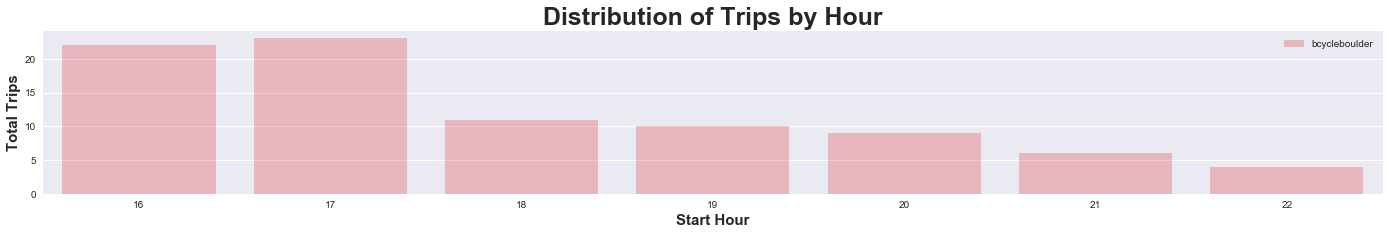

bcyclebroward - (2017-11-13 17:55:52 to 2017-11-14 01:10:55)


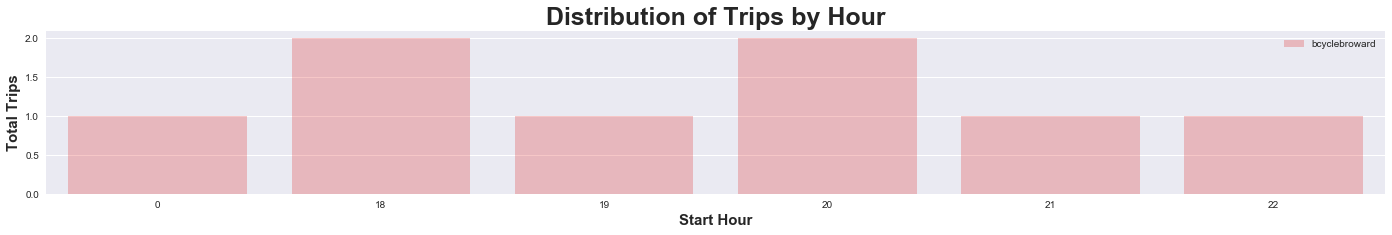

bcyclebublr - (2017-11-13 16:55:20 to 2017-11-14 00:10:28)


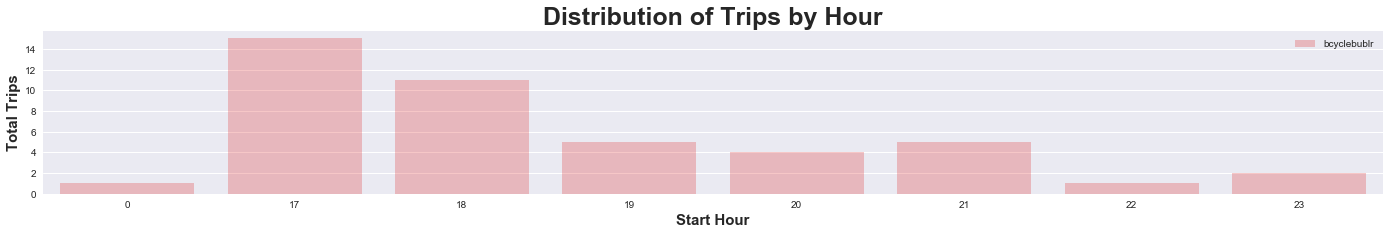

bcyclecatbike - (2017-11-13 17:56:06 to 2017-11-14 01:11:10)
Unable to plot bcyclecatbike
bcyclecharlotte - (2017-11-13 17:55:53 to 2017-11-14 01:10:56)


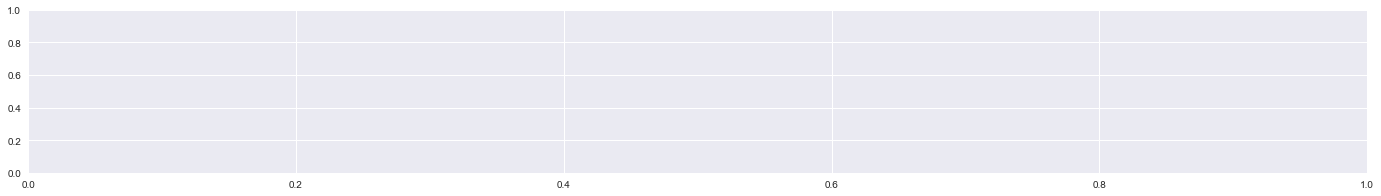

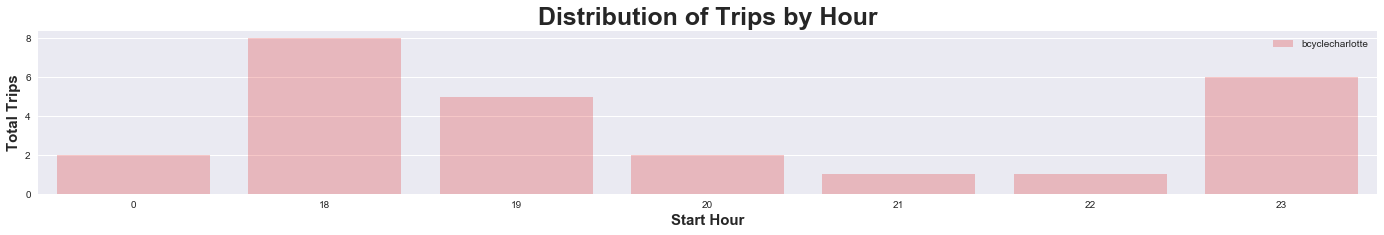

bcyclecincyredbike - (2017-11-13 17:55:54 to 2017-11-14 01:10:58)


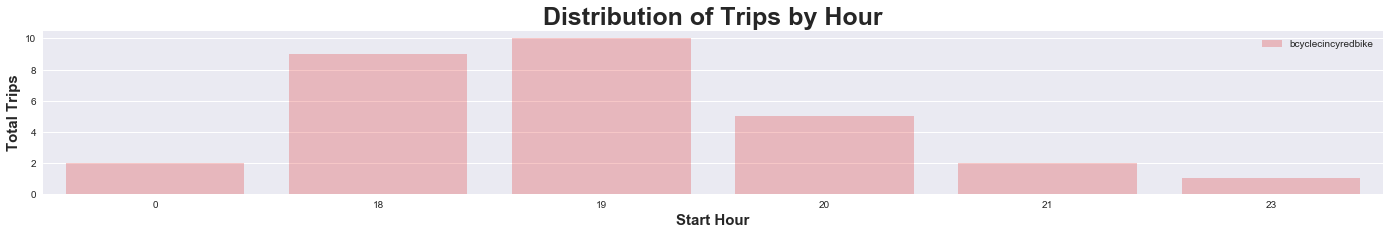

bcycleclarksville - (2017-11-13 16:55:21 to 2017-11-14 00:10:29)
Unable to plot bcycleclarksville
bcycleclemson - (2017-11-13 17:55:55 to 2017-11-14 01:10:58)


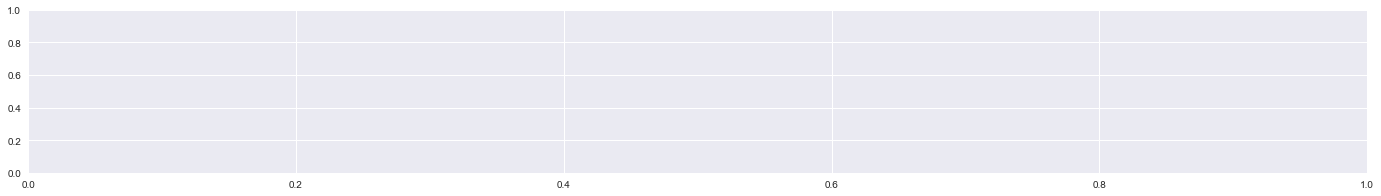

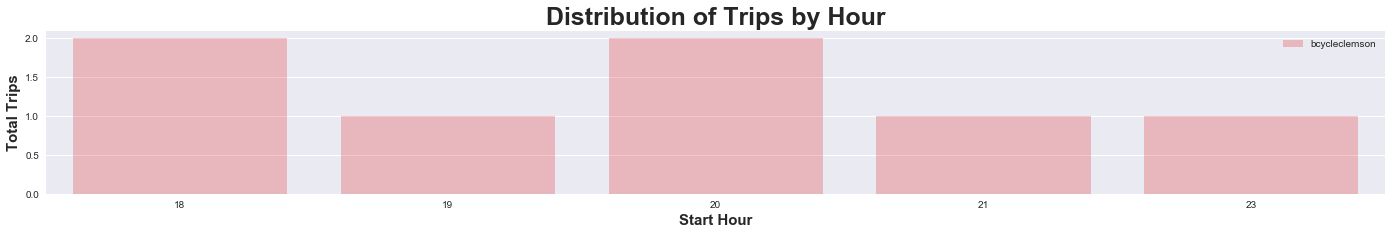

bcyclecolumbiacounty - (2017-11-13 17:55:58 to 2017-11-14 01:11:01)


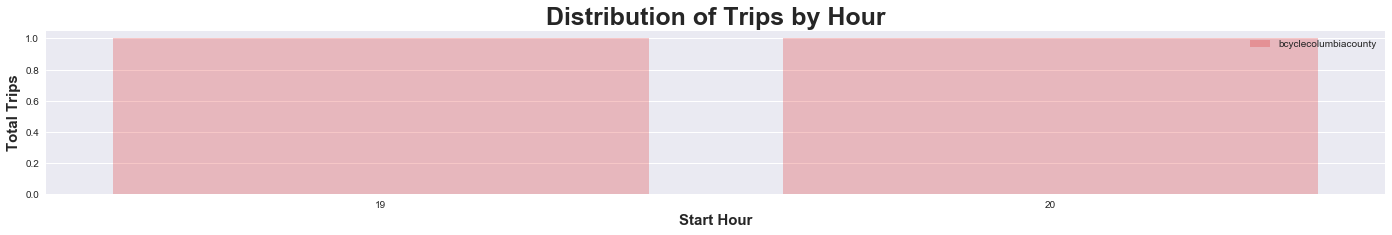

bcyclecolumbike - (2017-11-13 17:55:47 to 2017-11-14 01:10:50)
Unable to plot bcyclecolumbike
bcycledallasfairpark - (2017-11-13 16:55:21 to 2017-11-14 00:10:30)
Unable to plot bcycledallasfairpark
bcycledenver - (2017-11-13 15:54:41 to 2017-11-13 23:10:22)


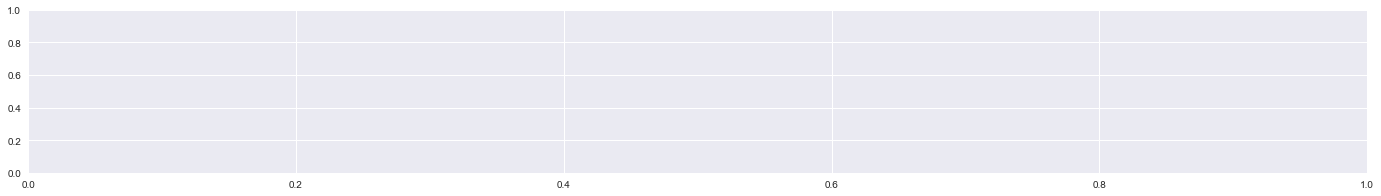

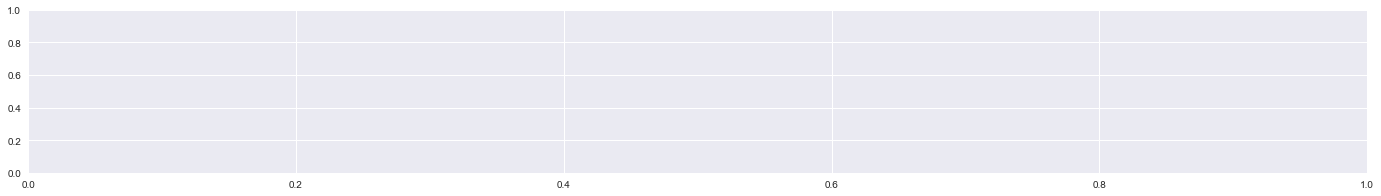

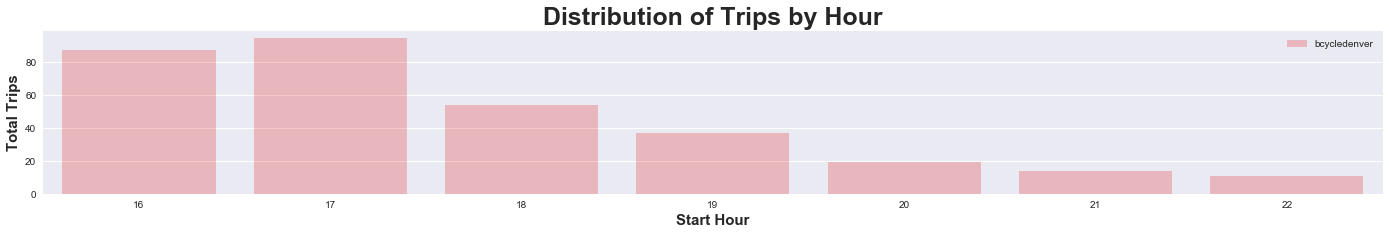

bcycledesmoines - (2017-11-13 16:55:22 to 2017-11-14 00:10:31)


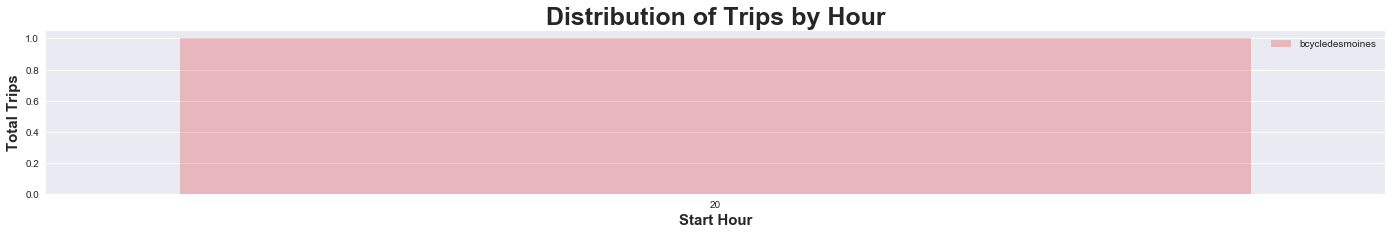

bcycleelpaso - (2017-11-13 16:55:23 to 2017-11-14 00:10:32)


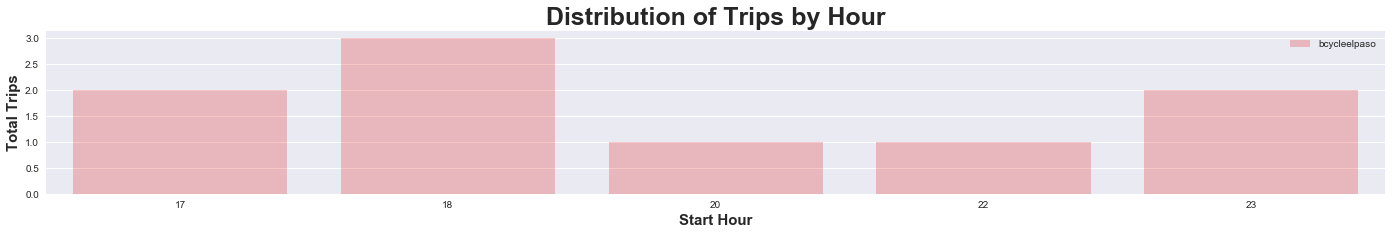

bcyclefortworth - (2017-11-13 16:55:25 to 2017-11-14 00:10:33)


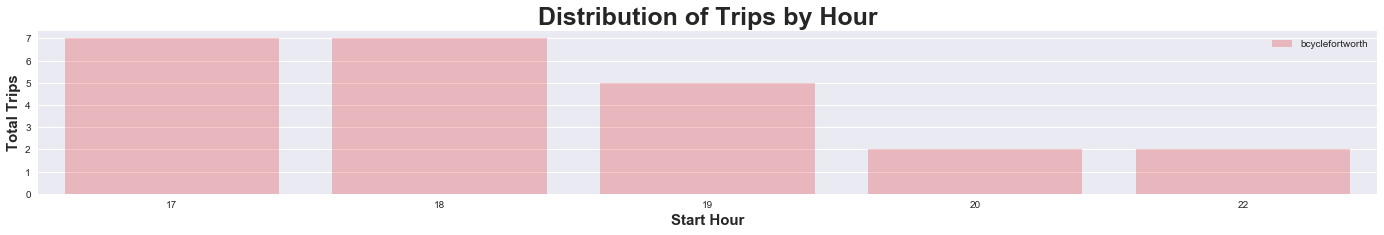

bcyclegreenbikeslc - (2017-11-13 15:55:15 to 2017-11-13 23:10:25)


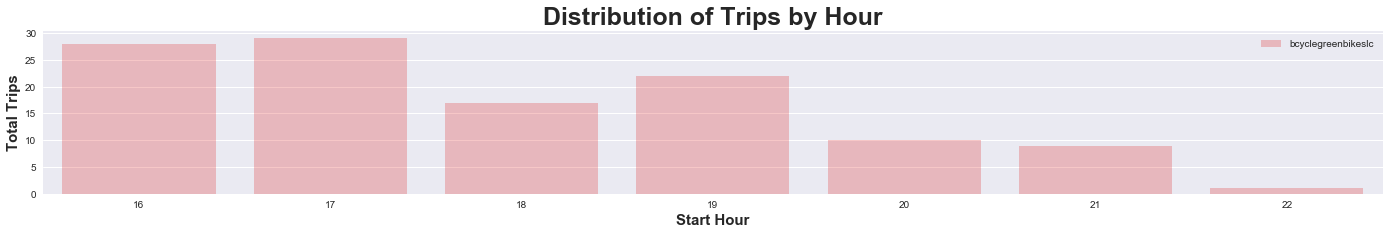

bcyclegreenville - (2017-11-13 17:55:59 to 2017-11-14 01:11:02)
Unable to plot bcyclegreenville
bcycleheartland - (2017-11-13 16:55:26 to 2017-11-14 00:10:34)


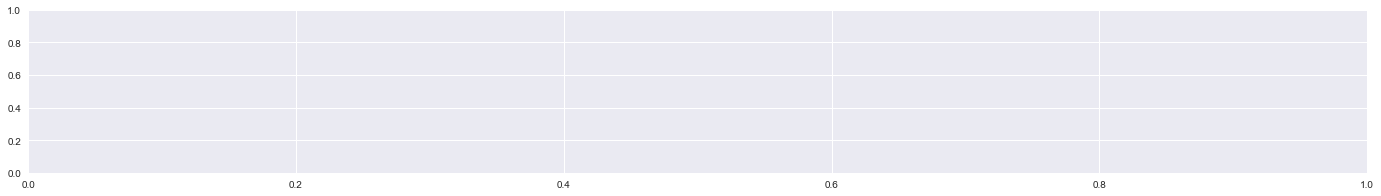

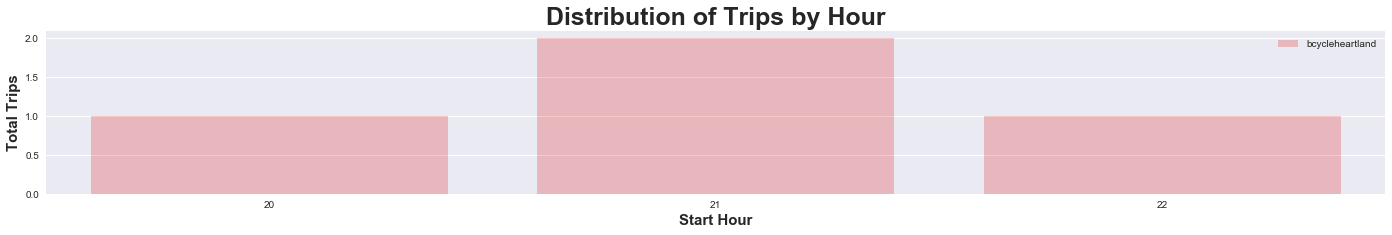

bcyclehouston - (2017-11-13 16:55:27 to 2017-11-14 00:10:35)


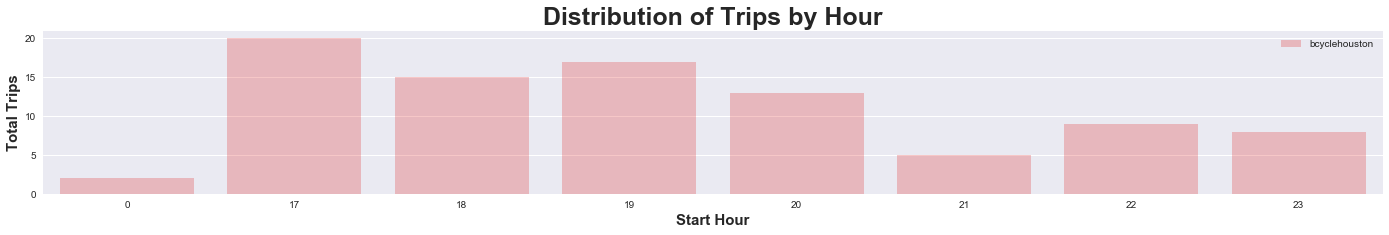

bcycleindego - (2017-11-13 17:56:00 to 2017-11-14 01:11:04)


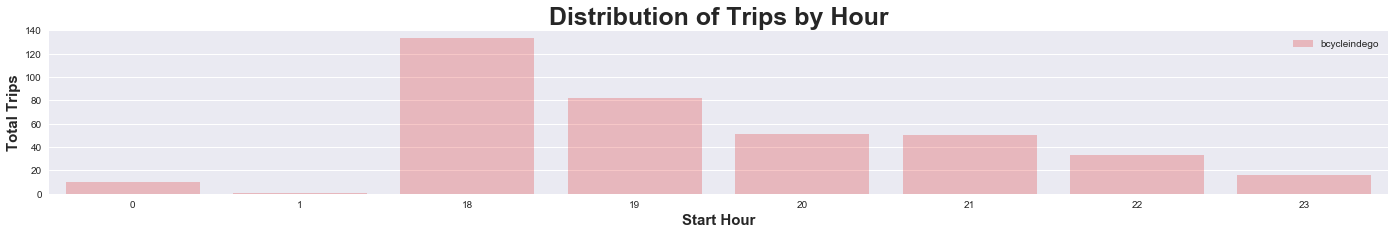

bcyclejacksoncounty - (2017-11-13 17:56:00 to 2017-11-14 01:11:05)
Unable to plot bcyclejacksoncounty
bcyclekc - (2017-11-13 16:55:28 to 2017-11-14 00:10:36)


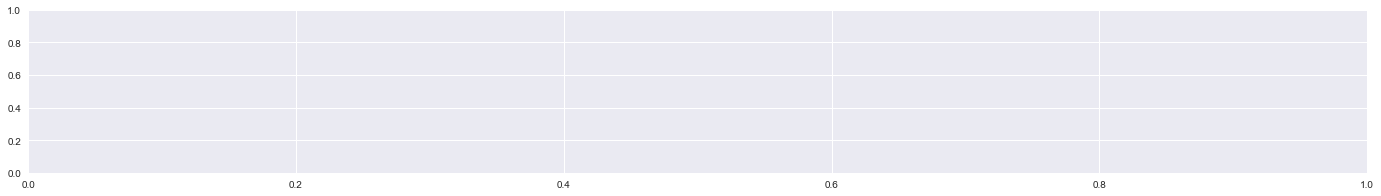

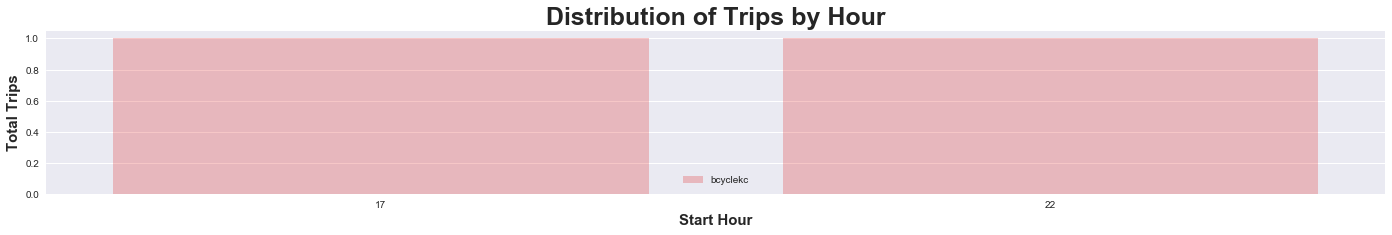

bcyclelametro - (2017-11-13 14:55:44 to 2017-11-13 22:10:38)


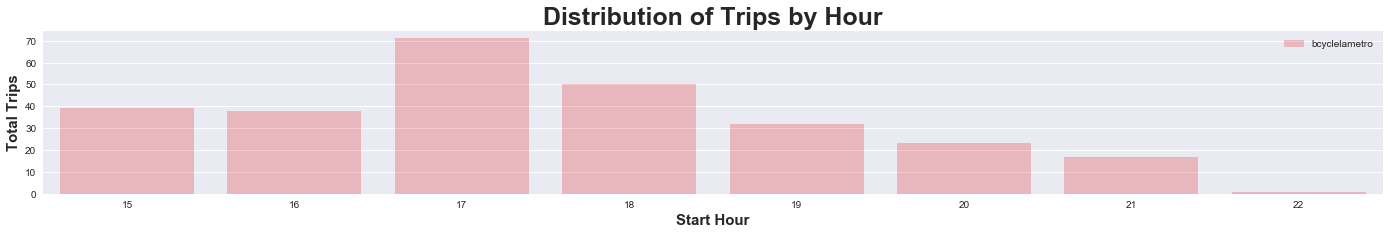

bcyclelinkdayton - (2017-11-13 17:56:03 to 2017-11-14 01:11:07)


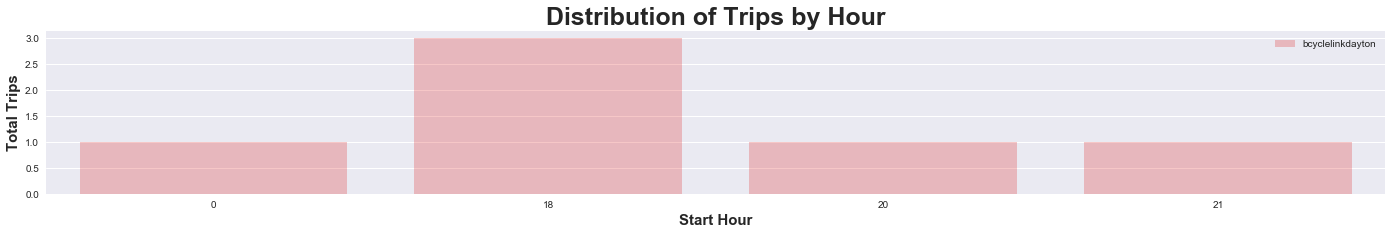

bcyclemadison - (2017-11-13 16:55:29 to 2017-11-14 00:10:00)


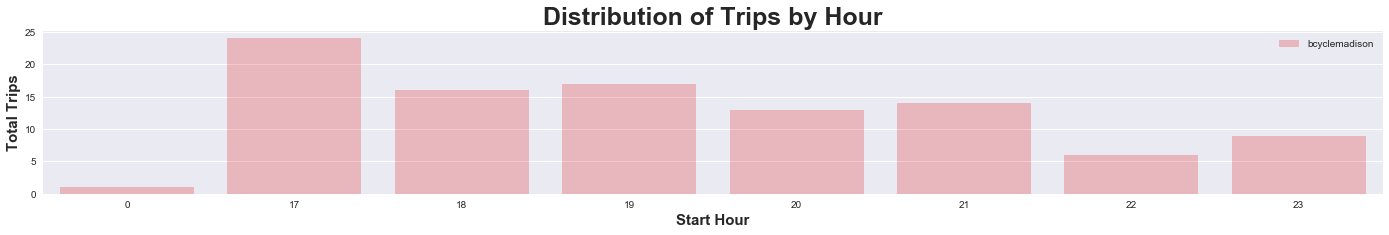

bcyclemcallen - (2017-11-13 16:55:30 to 2017-11-14 00:10:37)


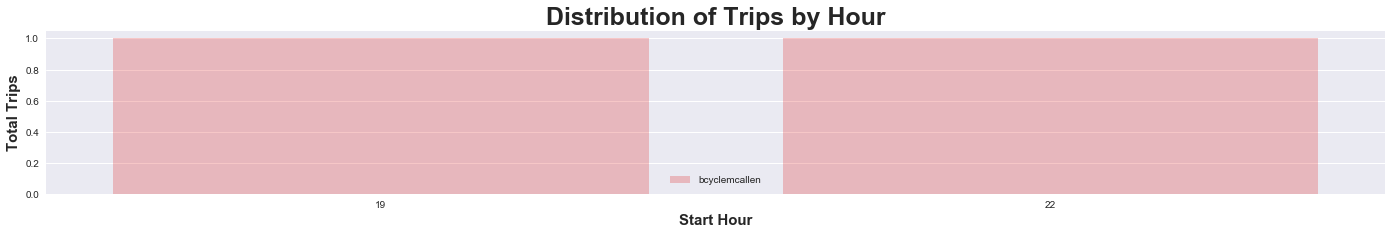

bcyclenashville - (2017-11-13 16:55:17 to 2017-11-14 00:10:26)


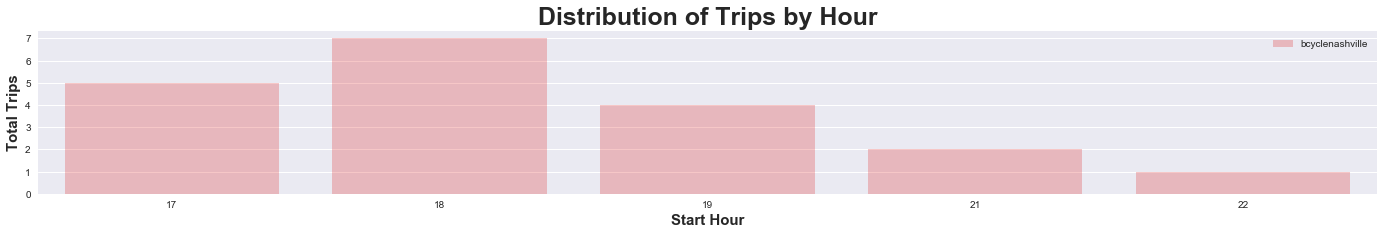

bcyclepacersbikeshare - (2017-11-13 17:55:48 to 2017-11-14 01:10:52)


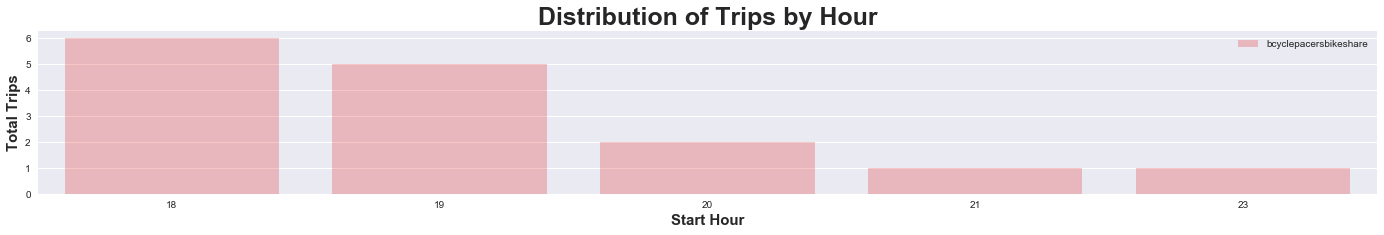

bcyclerapidcity - (2017-11-13 16:55:33 to 2017-11-14 00:10:40)
Unable to plot bcyclerapidcity
bcyclertcbikeshare - (2017-11-13 14:55:42 to 2017-11-13 22:10:48)


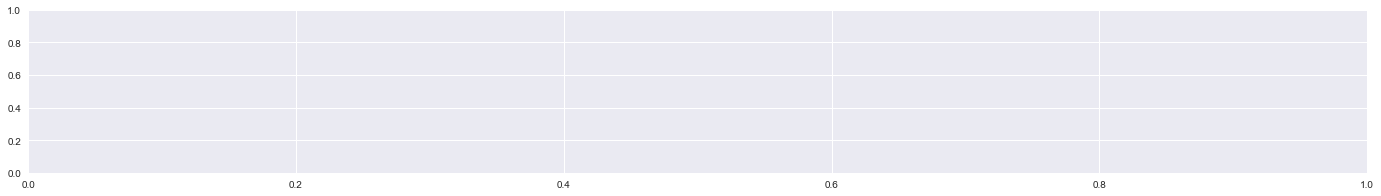

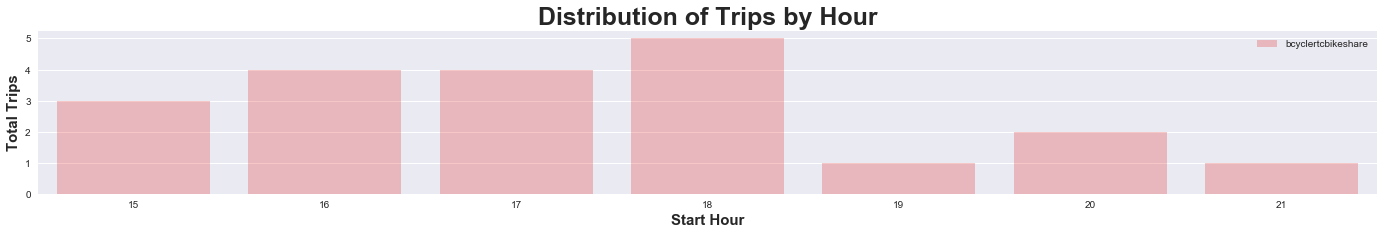

bcyclesanantonio - (2017-11-13 16:55:34 to 2017-11-14 00:10:41)


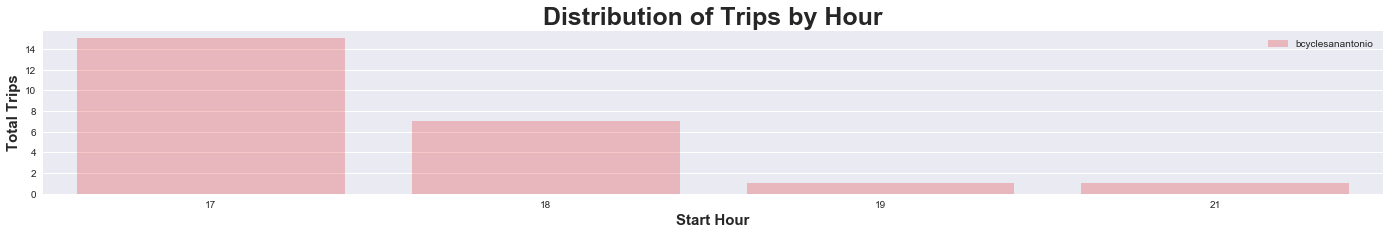

bcyclespartanburg - (2017-11-13 17:56:07 to 2017-11-14 01:11:11)
Unable to plot bcyclespartanburg
bcyclespokies - (2017-11-13 16:55:32 to 2017-11-14 00:10:39)


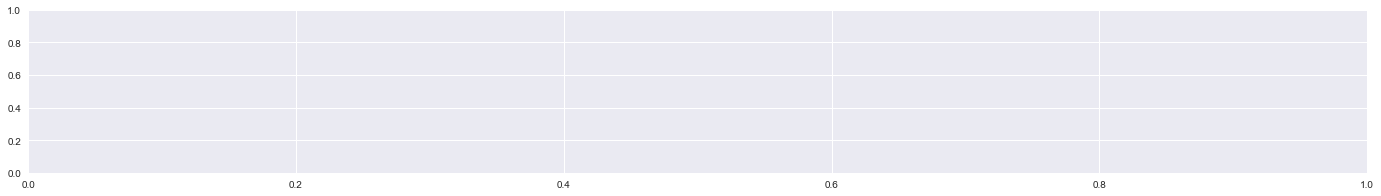

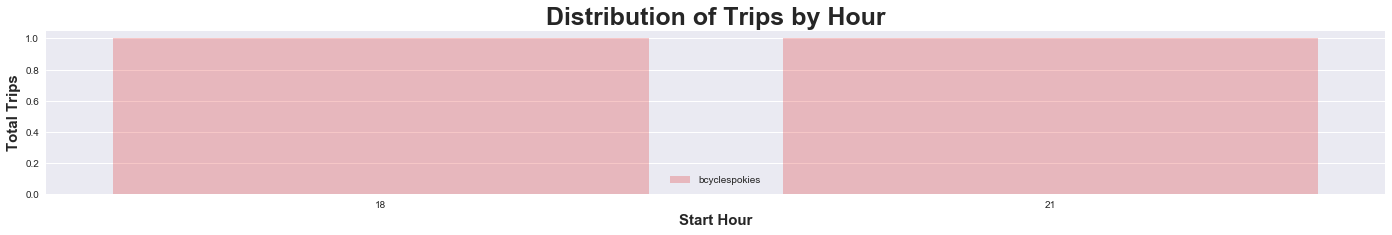

biketownpdx - (2017-11-13 14:55:39 to 2017-11-13 22:09:49)


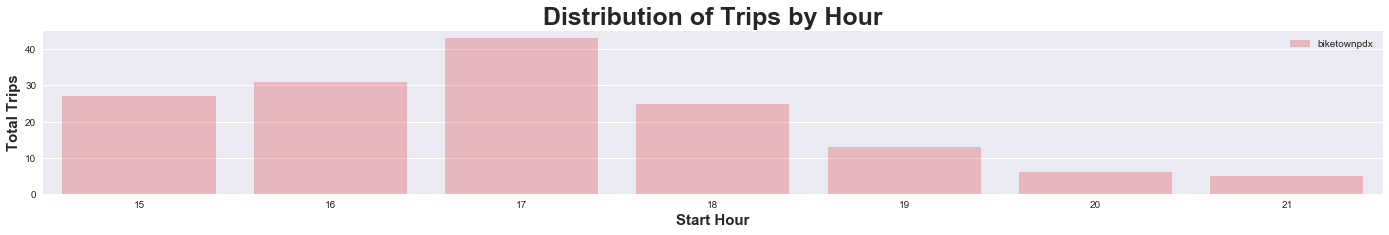

bishopranch - (2017-11-13 14:55:40 to 2017-11-13 22:10:45)


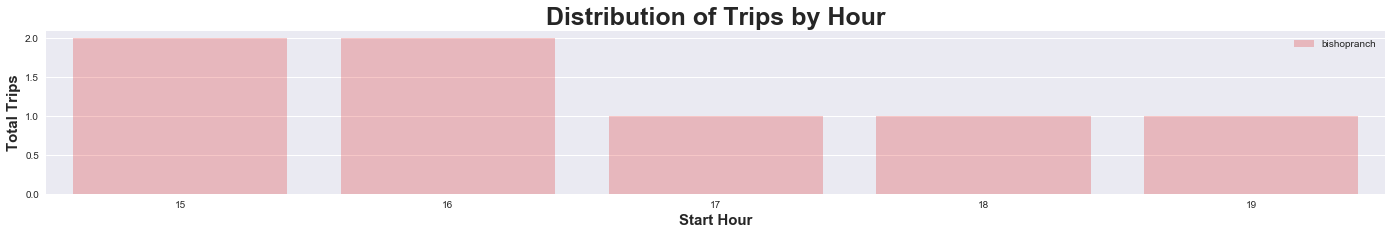

boisegreenbike - (2017-11-13 15:55:12 to 2017-11-13 23:10:21)


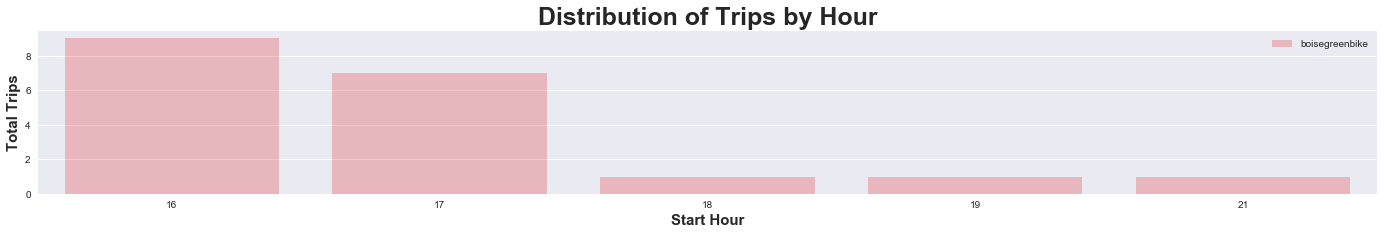

breezebikeshare - (2017-11-13 14:55:40 to 2017-11-13 22:10:46)


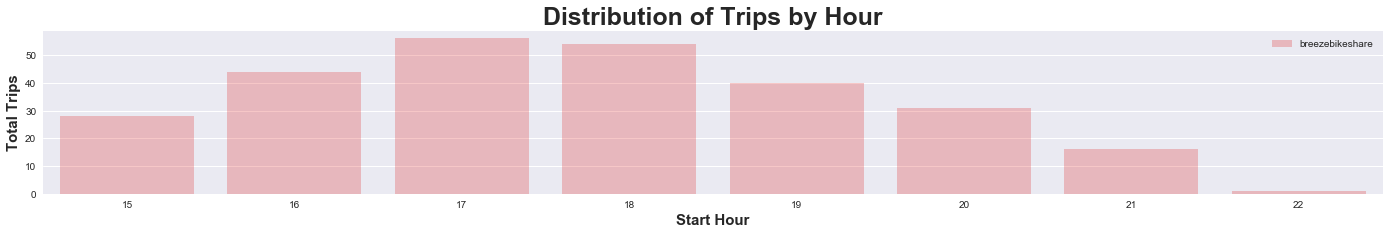

cabi - (2017-11-13 01:06:23 to 2017-11-14 01:10:05)


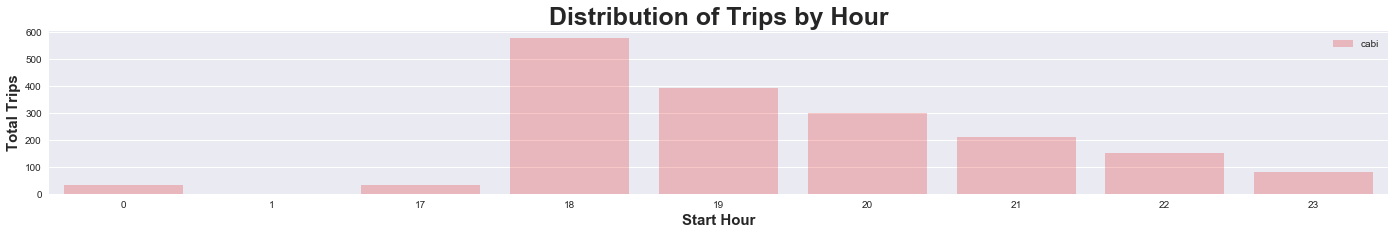

coastbikeshare - (2017-11-13 17:55:58 to 2017-11-14 01:11:00)


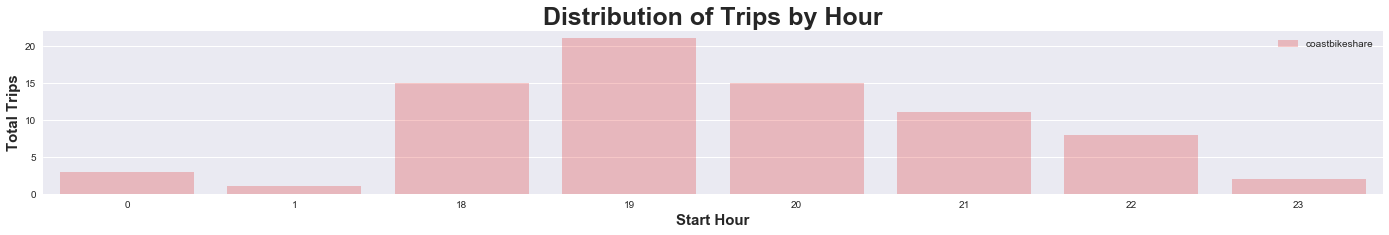

cogo - (2017-11-13 17:51:33 to 2017-11-14 01:11:06)


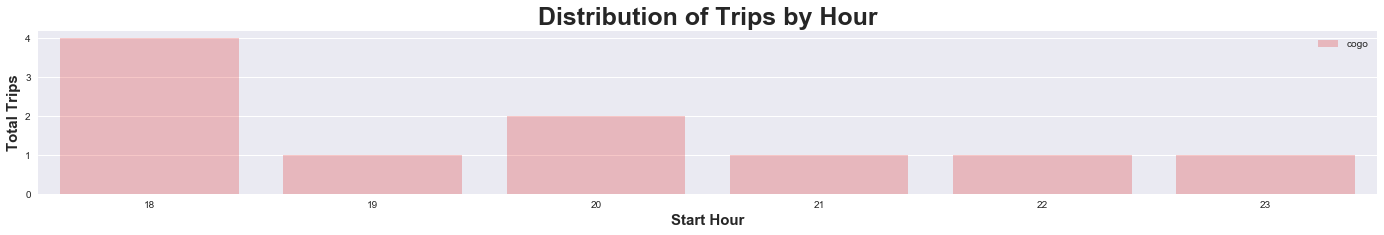

divvy - (2017-11-13 15:59:59 to 2017-11-14 00:10:27)


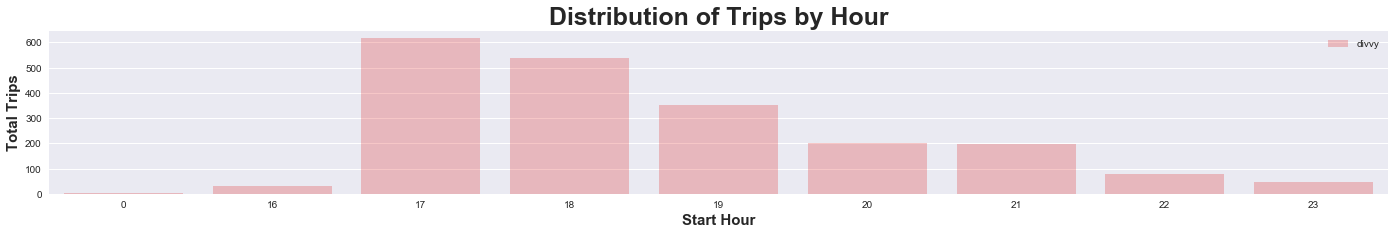

gridbikeshare - (2017-11-13 14:55:42 to 2017-11-13 22:10:47)


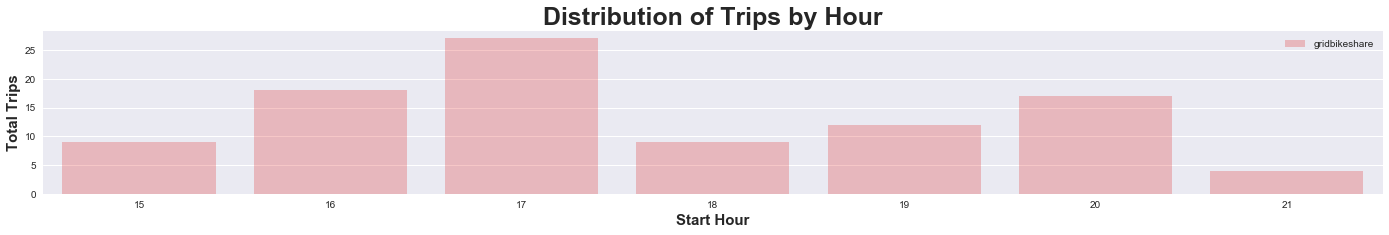

hubway - (2017-11-13 04:39:49 to 2017-11-14 01:07:13)


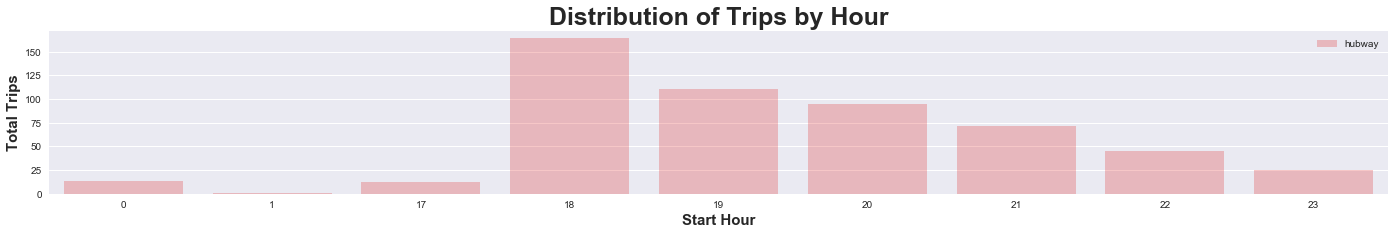

juicebikeshare - (2017-11-13 17:56:02 to 2017-11-14 01:11:07)


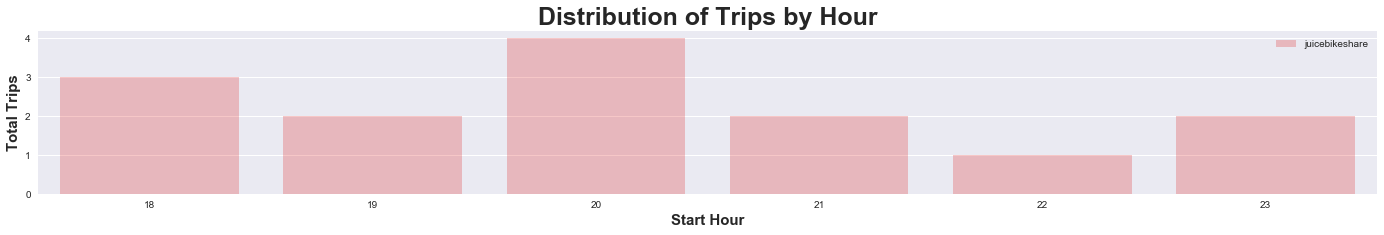

monashbikeshare - (2017-11-14 08:54:40 to 2017-11-14 16:09:48)


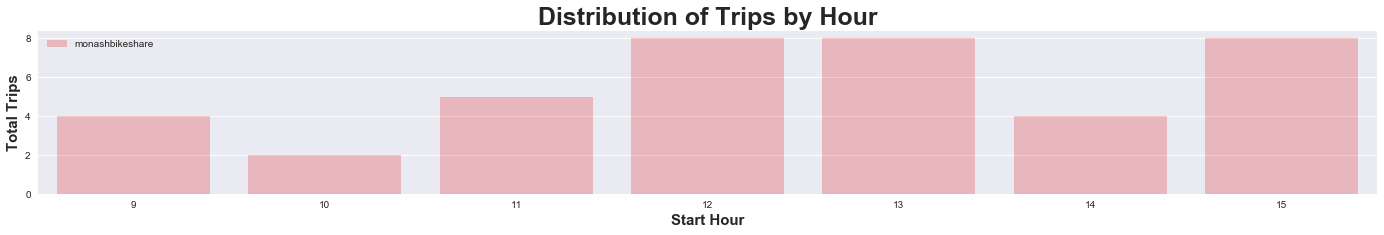

mountainridesbikeshare - (2017-11-13 15:55:16 to 2017-11-13 23:10:26)
Unable to plot mountainridesbikeshare
niceridemn - (2017-11-13 04:37:29 to 2017-11-13 04:51:23)
Unable to plot niceridemn
nyc - (2017-11-13 04:17:13 to 2017-11-14 01:10:58)


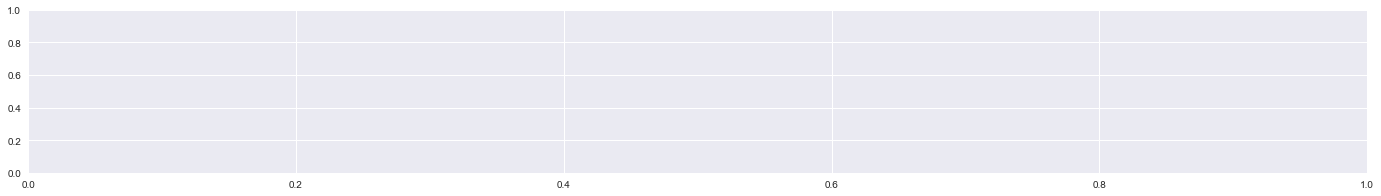

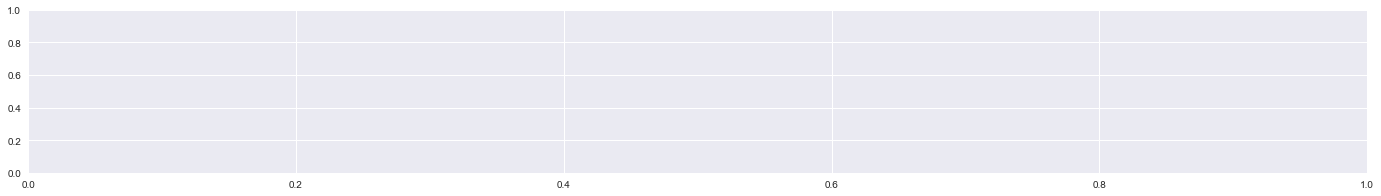

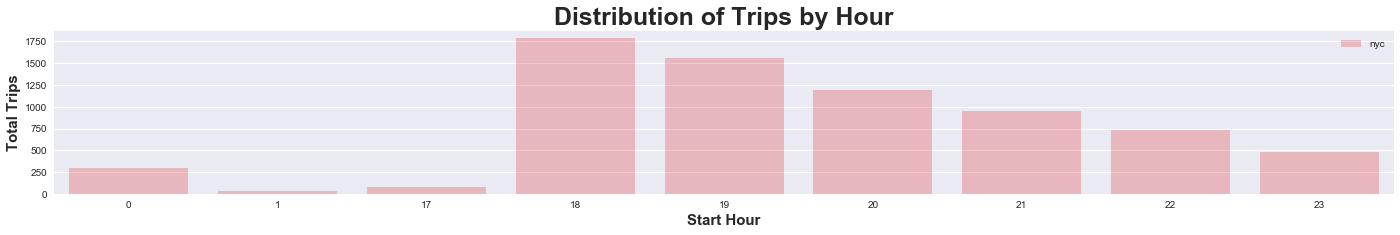

reddybikeshare - (2017-11-13 17:56:04 to 2017-11-14 01:11:09)


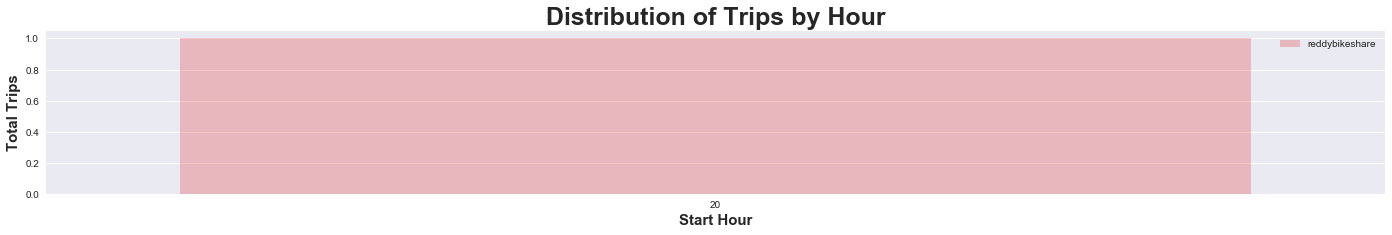

relaybikeshare - (2017-11-13 17:56:06 to 2017-11-14 01:11:10)


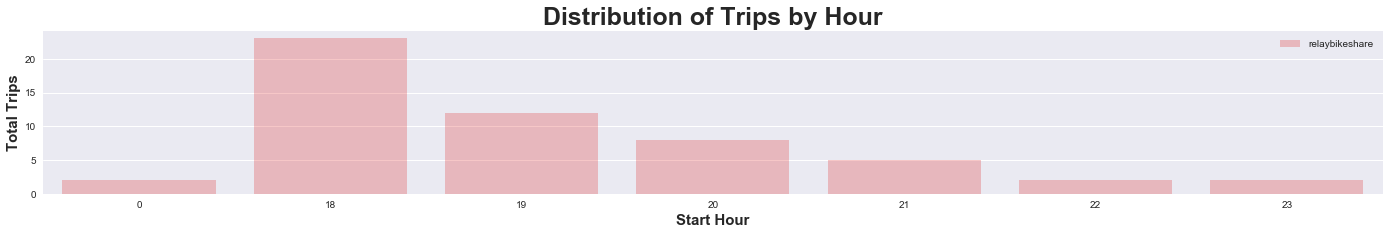

sobihamilton - (2017-11-13 17:54:37 to 2017-11-14 01:09:45)


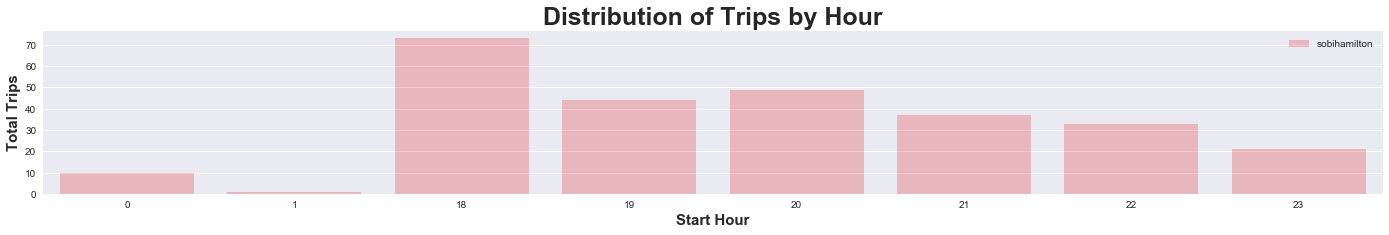

sobilongbeach - (2017-11-13 17:56:07 to 2017-11-14 01:11:11)


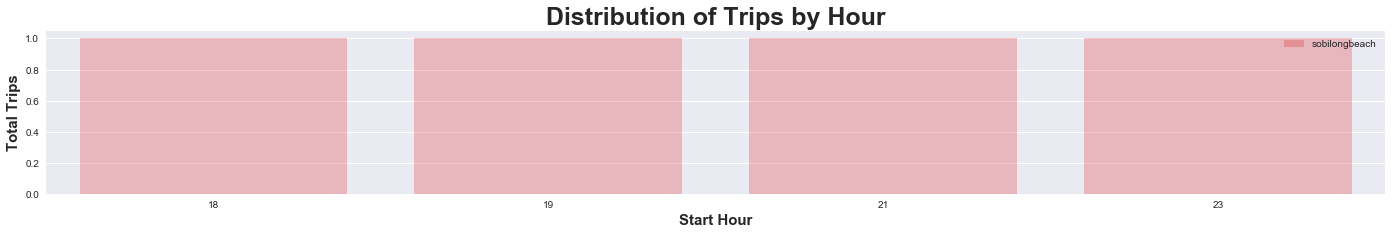

topekametrobikes - (2017-11-13 16:55:37 to 2017-11-14 00:10:43)


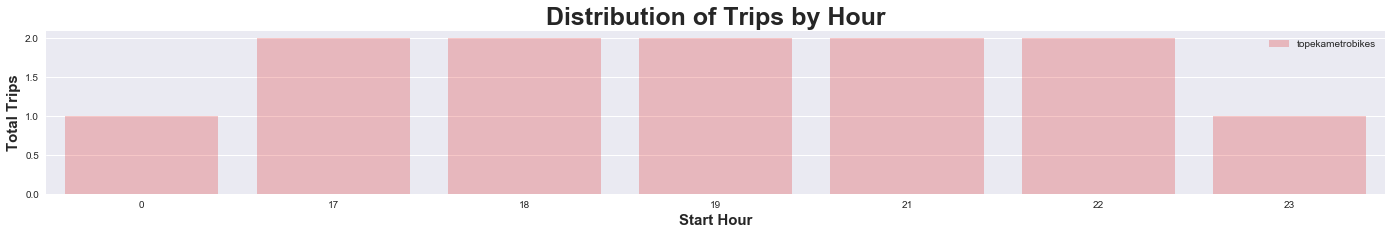

universityofvirginia - (2017-11-13 17:56:09 to 2017-11-14 01:11:13)


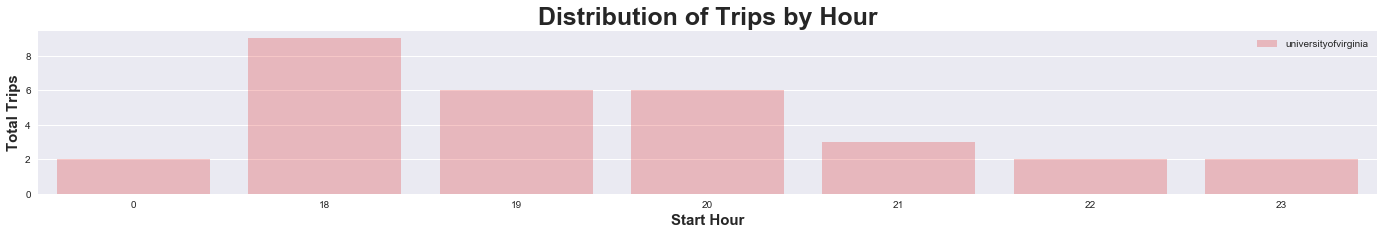

velgo - (2017-11-13 17:54:38 to 2017-11-14 01:09:46)


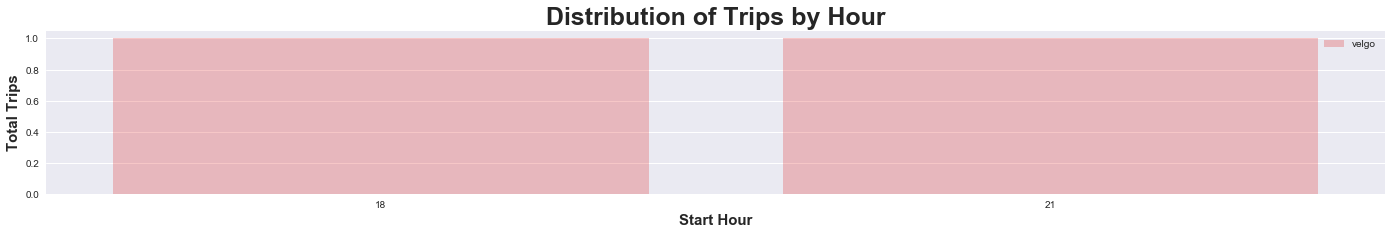

In [11]:
for pid in sorted(pd.unique(status_data.program_id)):
    df = status_data[status_data.program_id == pid].copy()
    print('%s - (%s to %s)' % (pid, df.time.min(), df.time.max()))
    plot_hourly_usage(df, title=pid.lower(), color='r')

In [12]:
def resample_status(df, interval='5T', verbose=False):
    if verbose:
        print('[%s] Resampling on interval' % datetime.datetime.now().time())
    
    resampled_list = []
    
    for pid in pd.unique(df.program_id):

            df_temp = df[df.program_id == pid].copy()
            
            df_temp.set_index(['station_id', 'time'], inplace=True)

            # resample on 5 minute interval mean
            df_temp = df_temp.groupby([pd.Grouper(level=0), pd.Grouper(freq=interval, level=-1)]).mean()
            df_temp.reset_index(inplace=True)
            
            df_temp['program_id'] = pid
         
            resampled_list.append(df_temp)

    resampled_df = pd.concat(resampled_list)
    resampled_df.reset_index(inplace=True, drop=True)
    
    if verbose:
        print('[%s] Complete' % datetime.datetime.now().time())
    return resampled_df

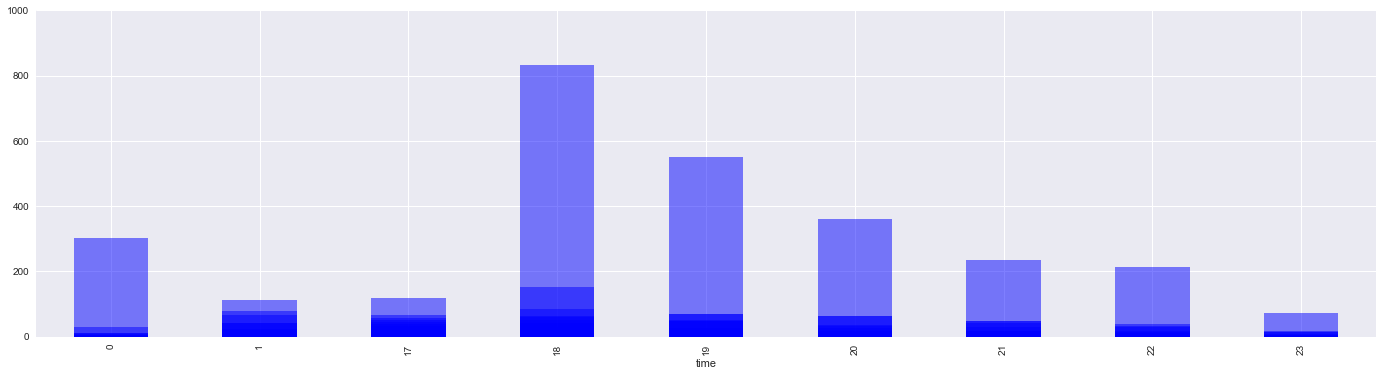

In [13]:
fig, ax = plt.subplots(figsize=(24,6))
for pid in pd.unique(status_data.program_id):
    status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_starting.sum().plot(kind='bar', color='b', alpha= 0.5, ax=ax)

ax.set_ylim(0, 1000)
plt.show()

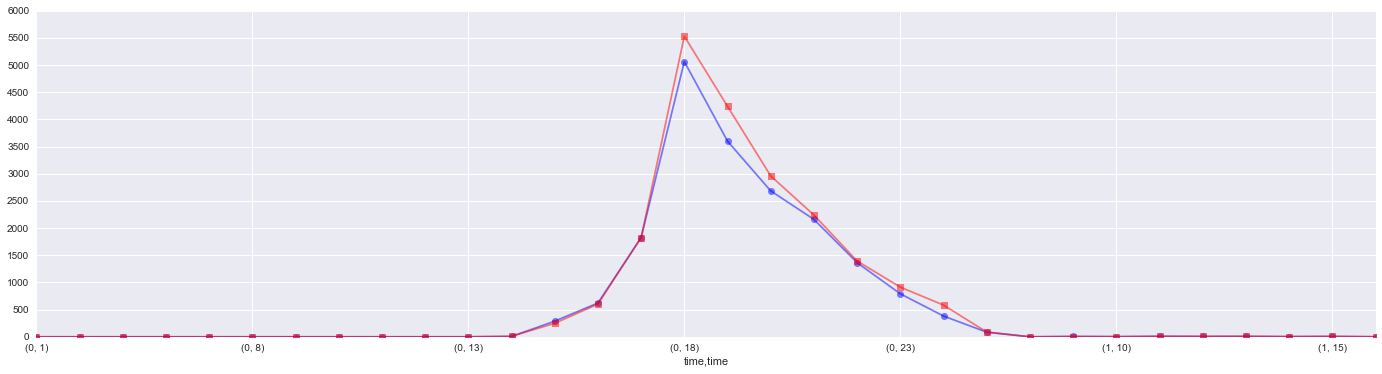

In [14]:
d0 = status_data.groupby([status_data.time.dt.dayofweek, status_data.time.dt.hour]).trips_starting.sum()
d1 = status_data.groupby([status_data.time.dt.dayofweek, status_data.time.dt.hour]).trips_ending.sum()

ax = d0.plot(figsize=(24,6), color='b', alpha=0.5, marker='o')
d1.plot(ax=ax, color='r', alpha=0.5, marker='s')


y_tick_interval = 500
y_max = math.ceil(d0.max()/y_tick_interval)*y_tick_interval

if math.ceil(d1.max()/y_tick_interval)*y_tick_interval > y_max:
    y_max = math.ceil(d1.max()/y_tick_interval)*y_tick_interval

y_tick_max = int(y_max/y_tick_interval*1.1)

ax.set_ylim(0, y_max)
ax.set_yticks([y*y_tick_interval for y in range(0, y_tick_max)])

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(24,6))
y_max = 0
for pid in pd.unique(status_data.program_id):
    status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_starting.sum().plot(color='b', alpha= 0.5, ax=ax, marker='o')
    status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_ending.sum().plot(color='r', alpha= 0.5, ax=ax, marker='s')
    
    if status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_starting.sum().max() > y_max:
        y_max = status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_starting.sum().max()
    
    if status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_ending.sum().max() > y_max:
        y_max = status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_ending.sum().max()
    

# ax.set_ylim(0, 1000)

y_tick_interval = 250
y_max = math.ceil(y_max/y_tick_interval)*y_tick_interval
y_tick_max = int(y_max/y_tick_interval)+1

ax.set_ylim(0, y_max)
ax.set_yticks([y*y_tick_interval for y in range(0, y_tick_max)])

plt.show()

In [16]:
print('Program ID\t\t\tTrips Starting\tTrips Ending\tNet')
for pid in pd.unique(status_data.program_id):
    S = status_data[status_data.program_id == pid].trips_starting.sum()
    E = status_data[status_data.program_id == pid].trips_ending.sum()
    print('%s\t%s\t\t%s\t\t%s' % (pid.ljust(25), str(S), str(E), S-E))

Program ID			Trips Starting	Trips Ending	Net
ba                       	1278.0		1327.0		-49.0
bcyclearborbike          	8.0		9.0		-1.0
bcycleaustin             	124.0		132.0		-8.0
bcycleaventura           	5.0		5.0		0.0
bcyclebattlecreek        	0.0		0.0		0.0
bcycleboulder            	83.0		92.0		-9.0
bcyclebroward            	9.0		14.0		-5.0
bcyclebublr              	48.0		50.0		-2.0
bcyclecatbike            	0.0		0.0		0.0
bcyclecharlotte          	31.0		36.0		-5.0
bcyclecincyredbike       	27.0		30.0		-3.0
bcycleclarksville        	1.0		0.0		1.0
bcycleclemson            	7.0		7.0		0.0
bcyclecolumbiacounty     	3.0		3.0		0.0
bcyclecolumbike          	0.0		0.0		0.0
bcycledallasfairpark     	0.0		0.0		0.0
bcycledenver             	383.0		417.0		-34.0
bcycledesmoines          	1.0		1.0		0.0
bcycleelpaso             	19.0		19.0		0.0
bcyclefortworth          	20.0		29.0		-9.0
bcyclegreenbikeslc       	159.0		163.0		-4.0
bcyclegreenville         	0.0		0.0		0.0
bcycleheartland          	6.0		

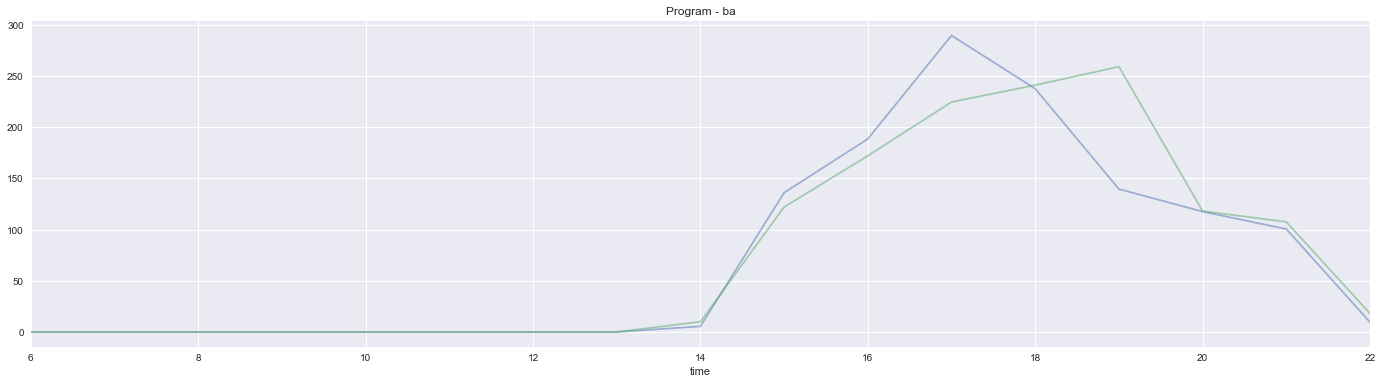

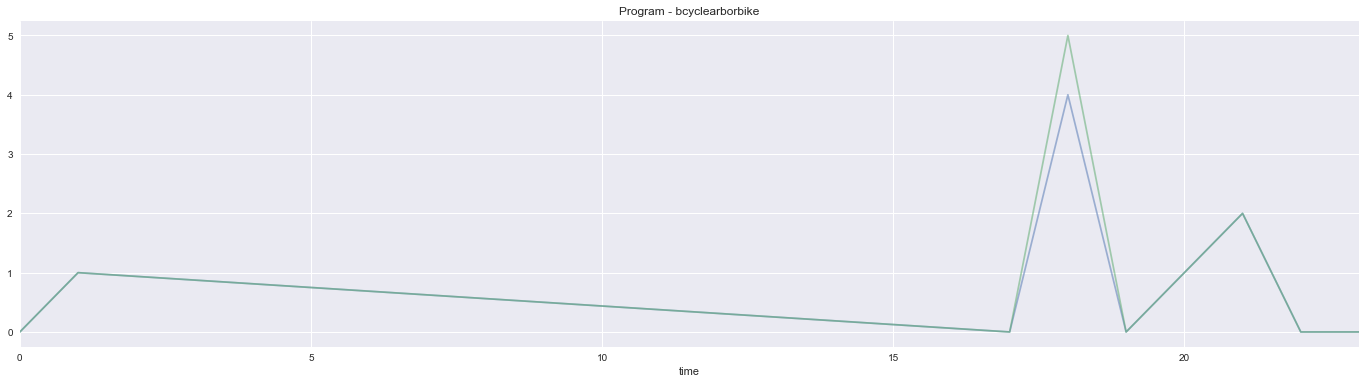

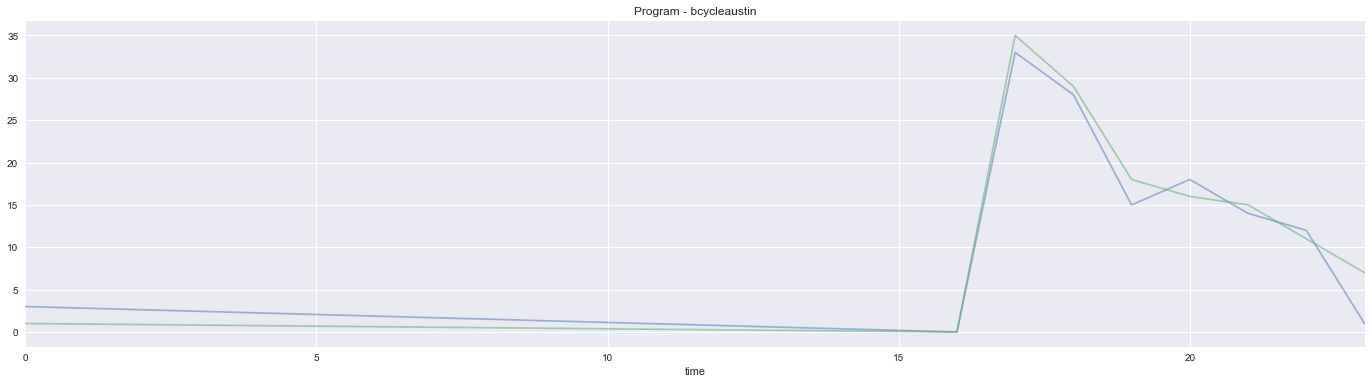

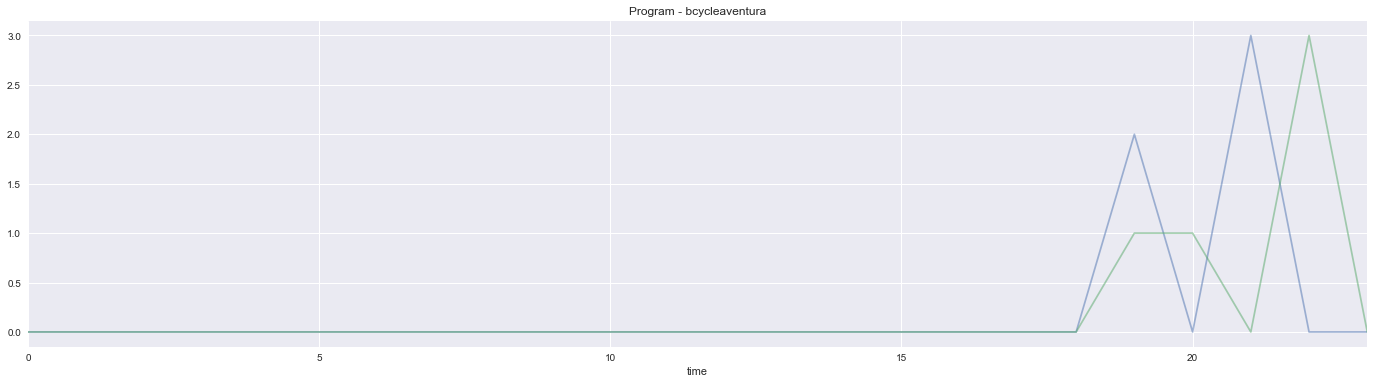

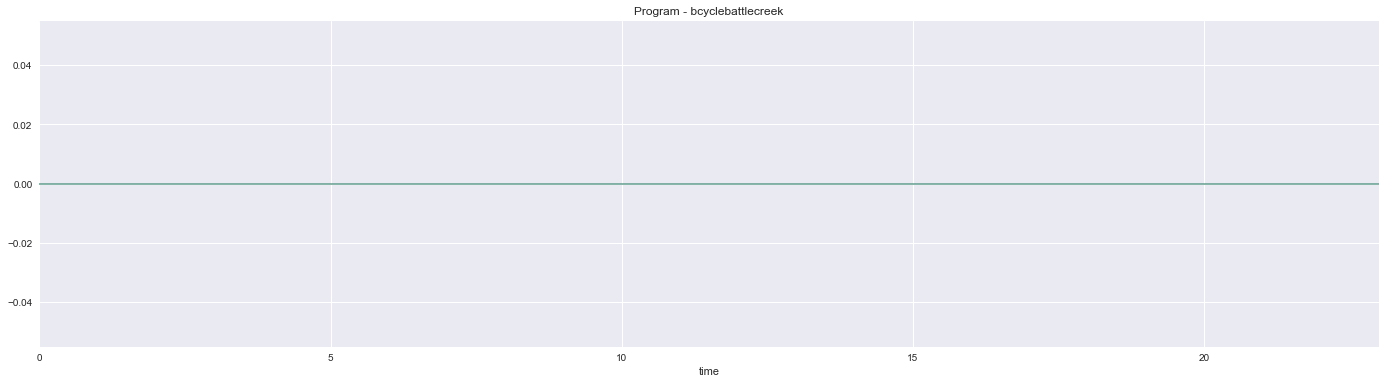

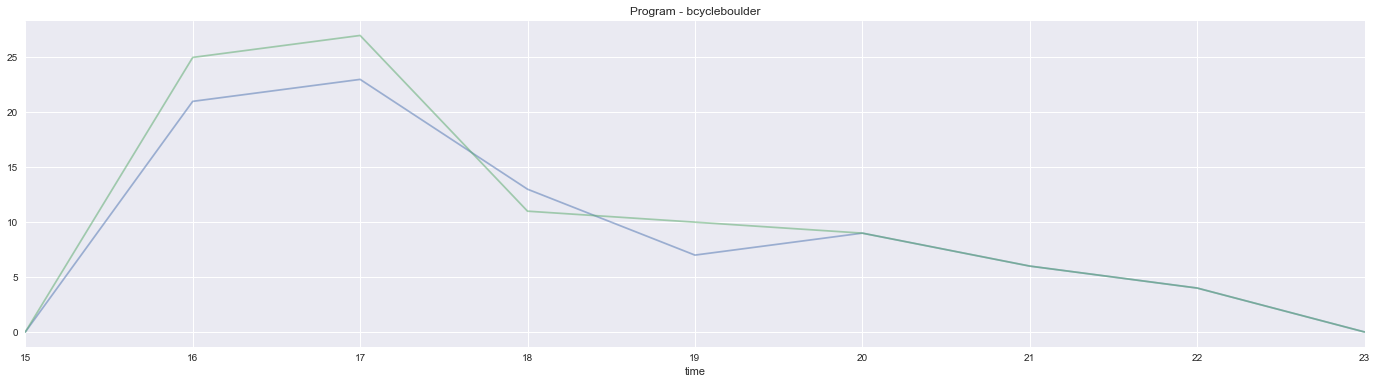

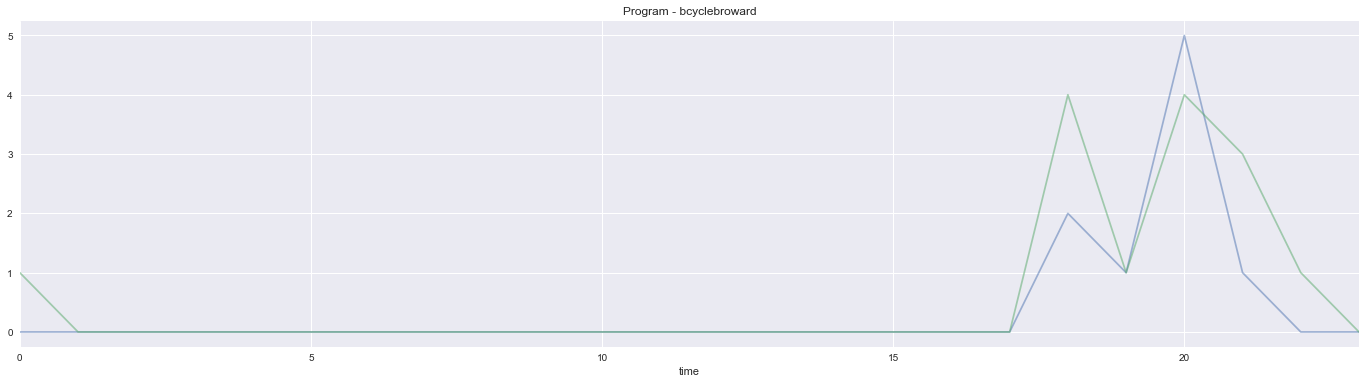

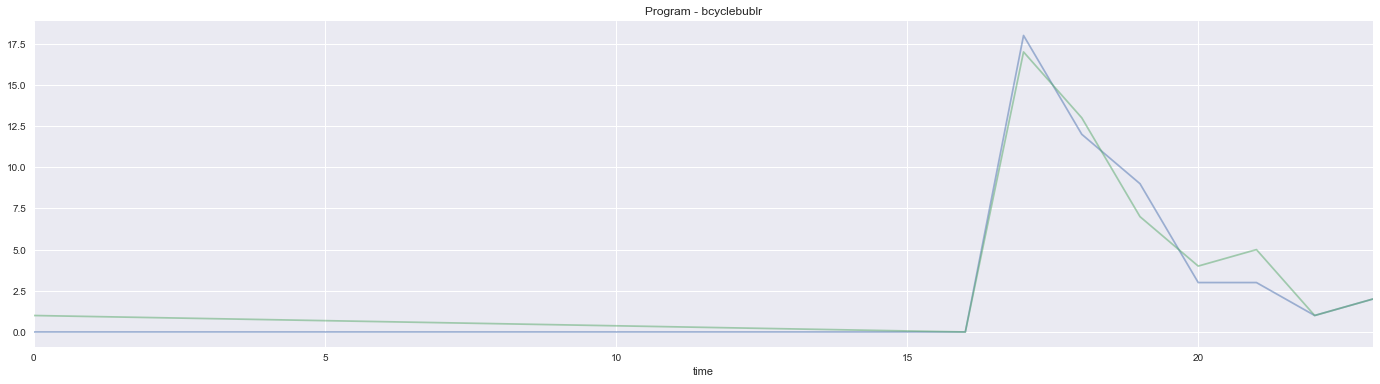

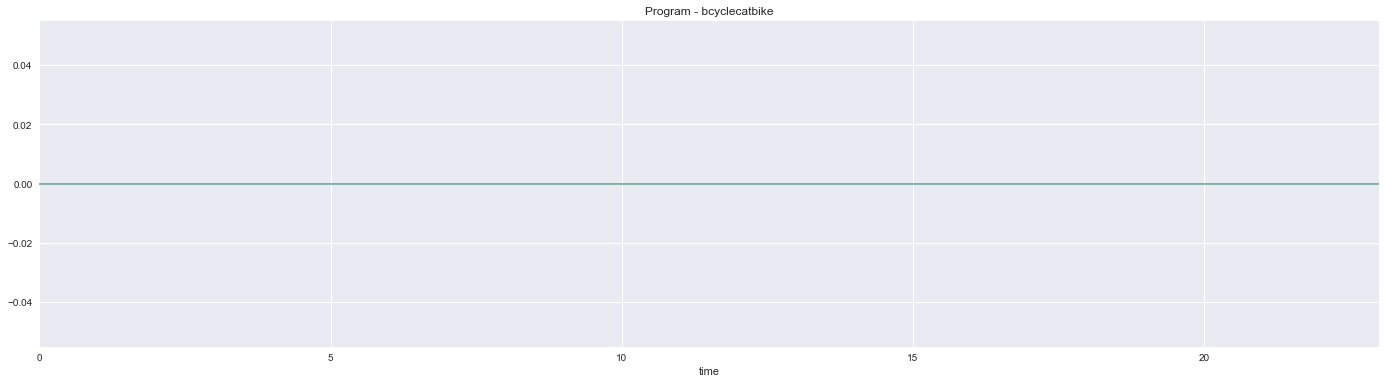

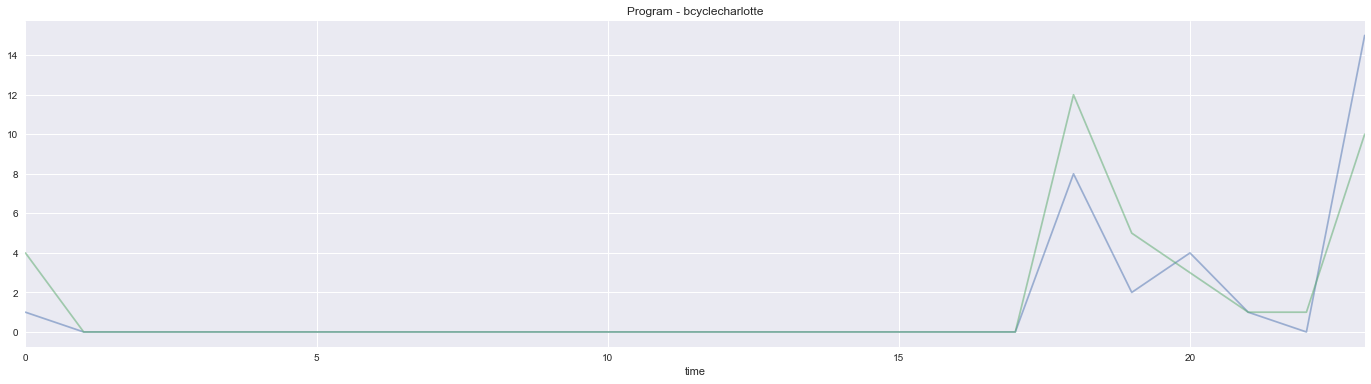

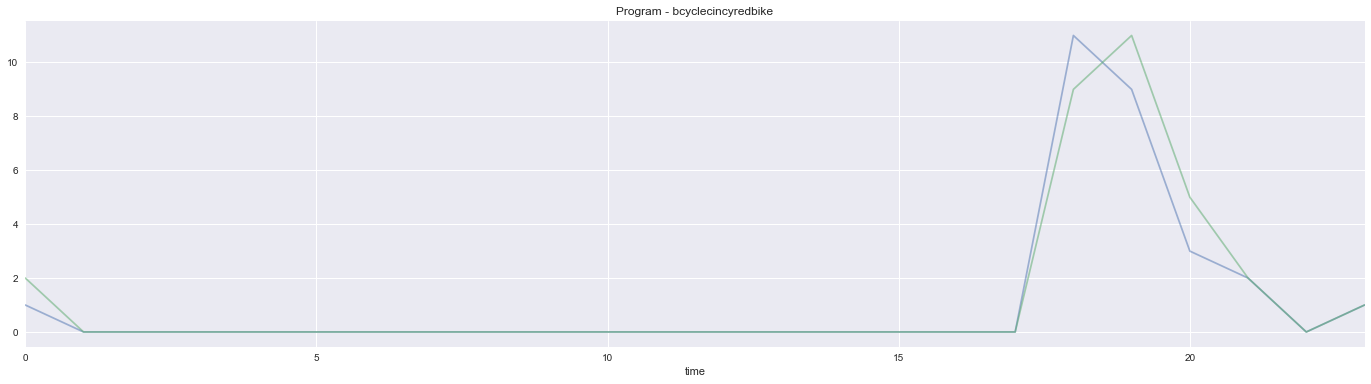

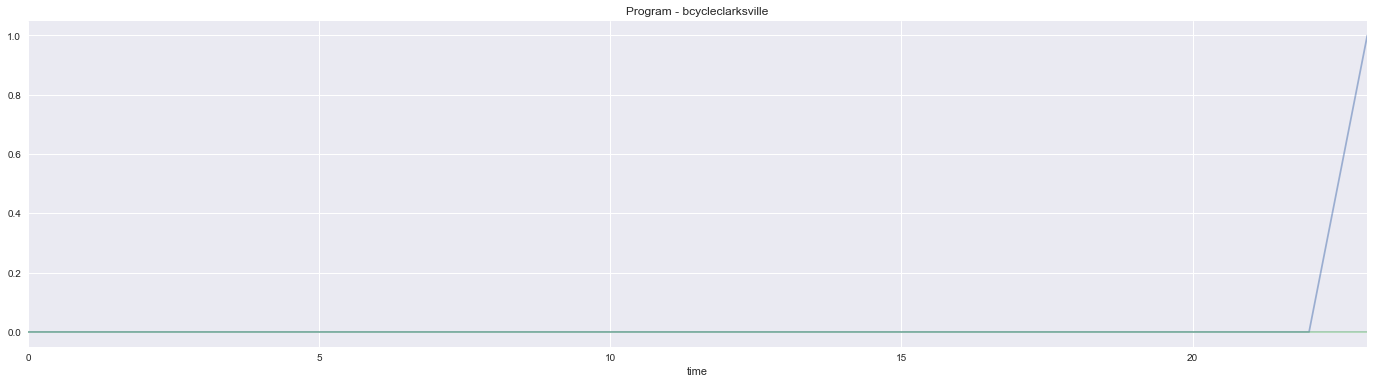

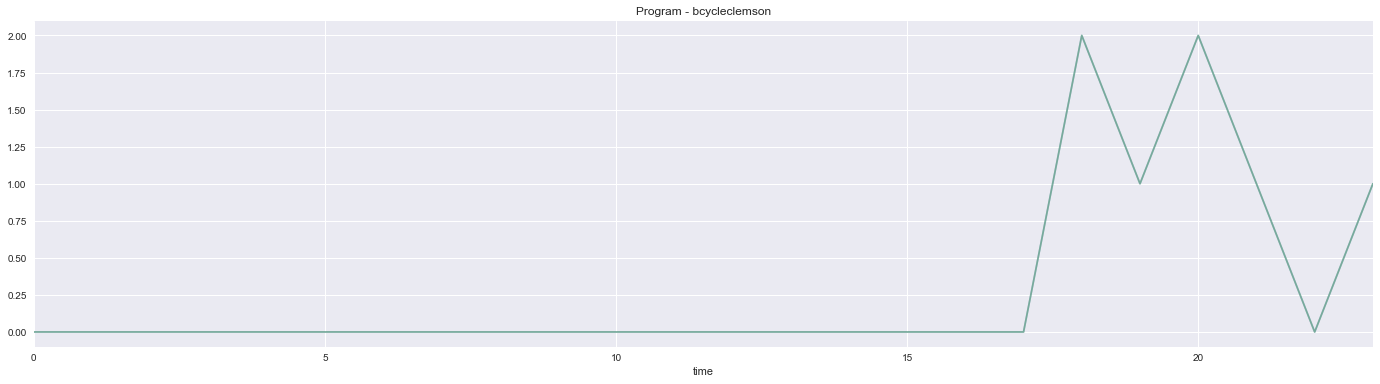

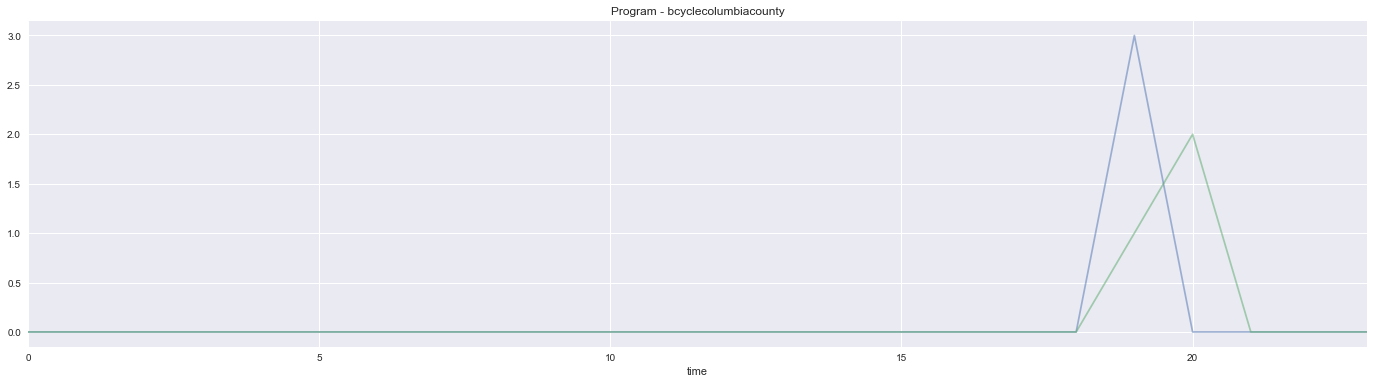

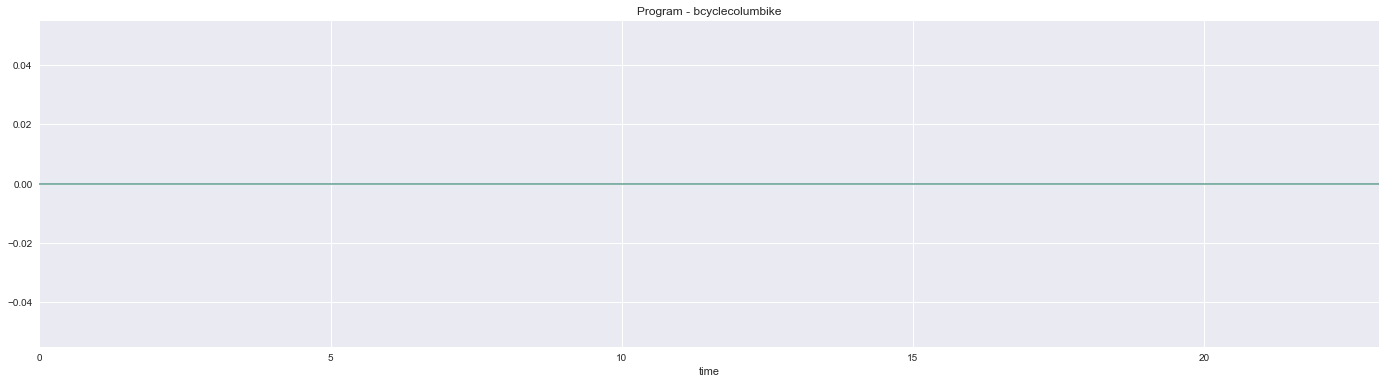

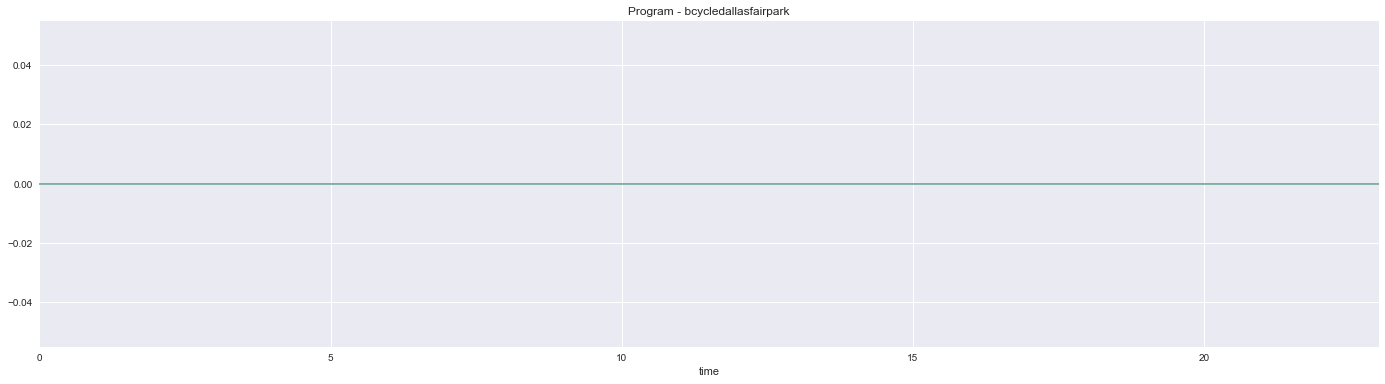

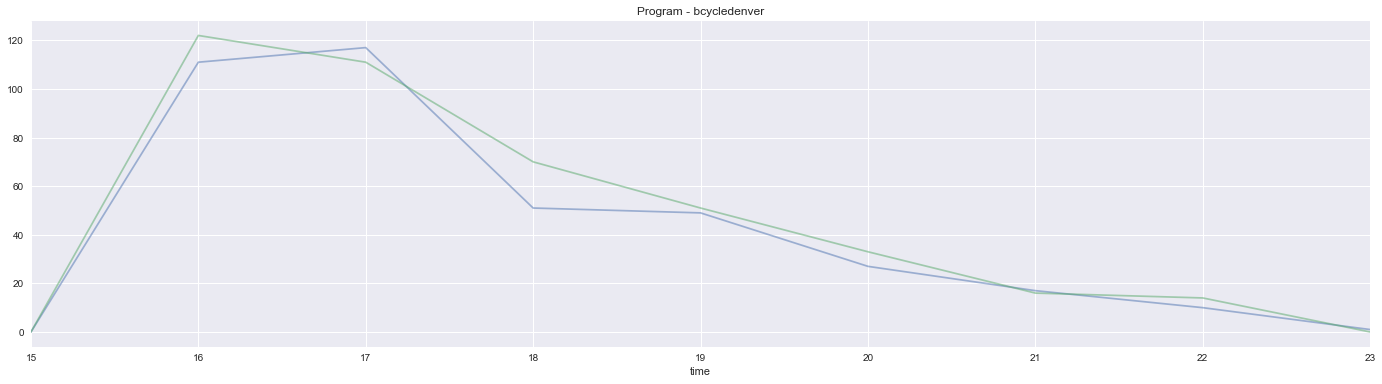

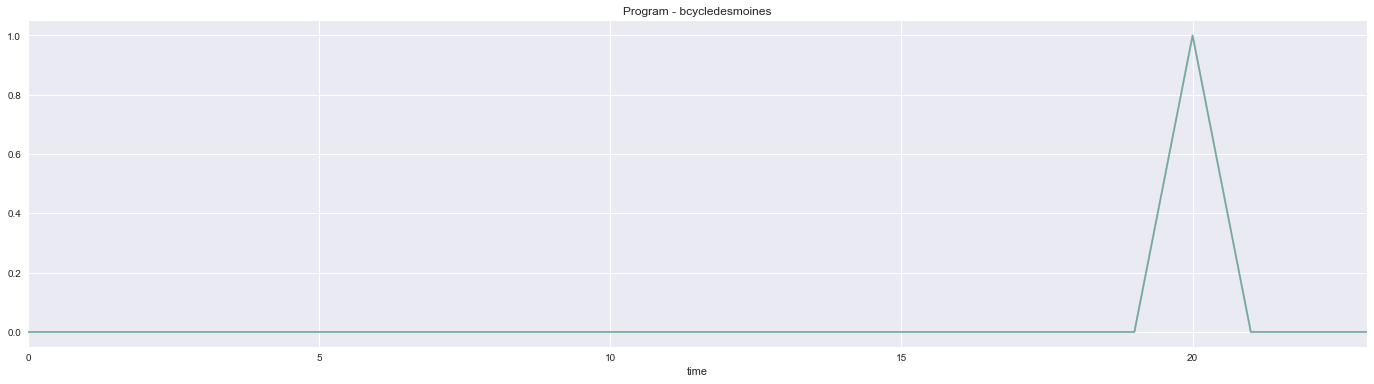

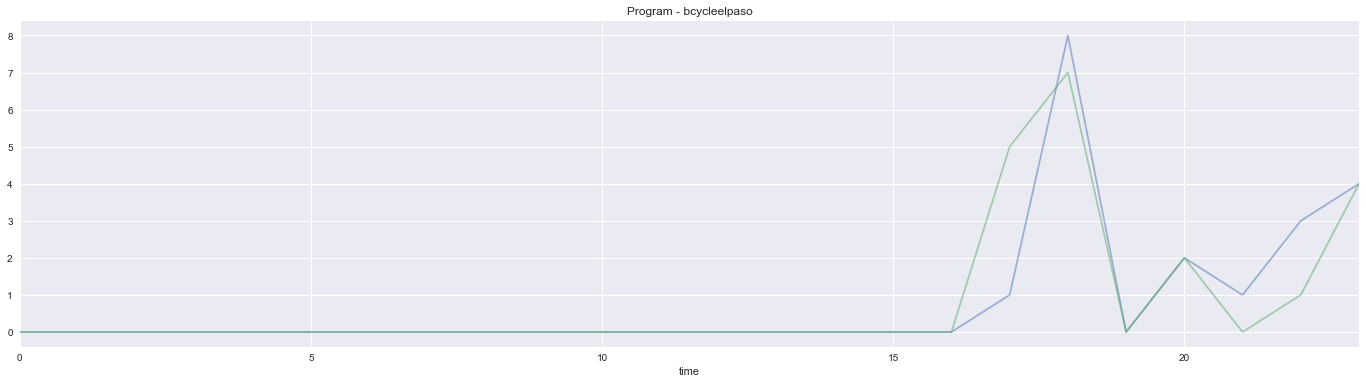

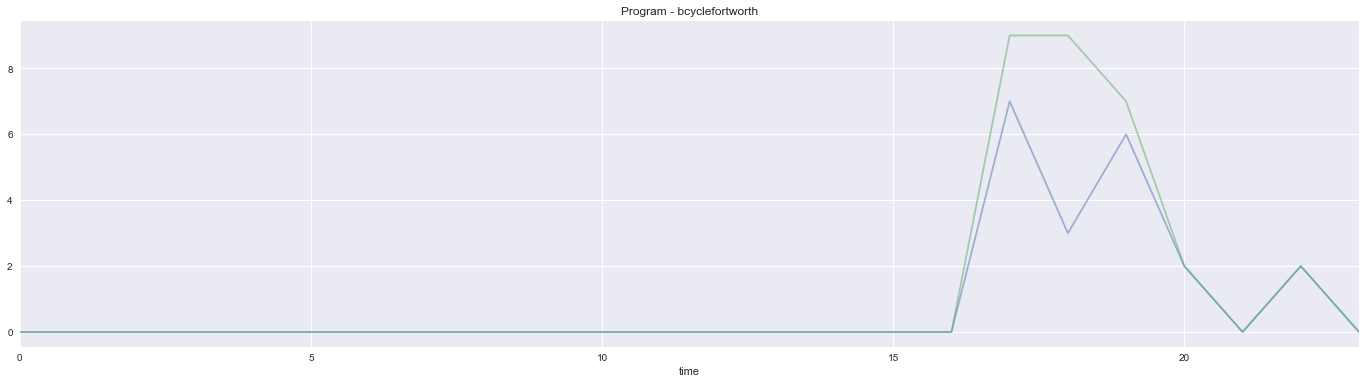

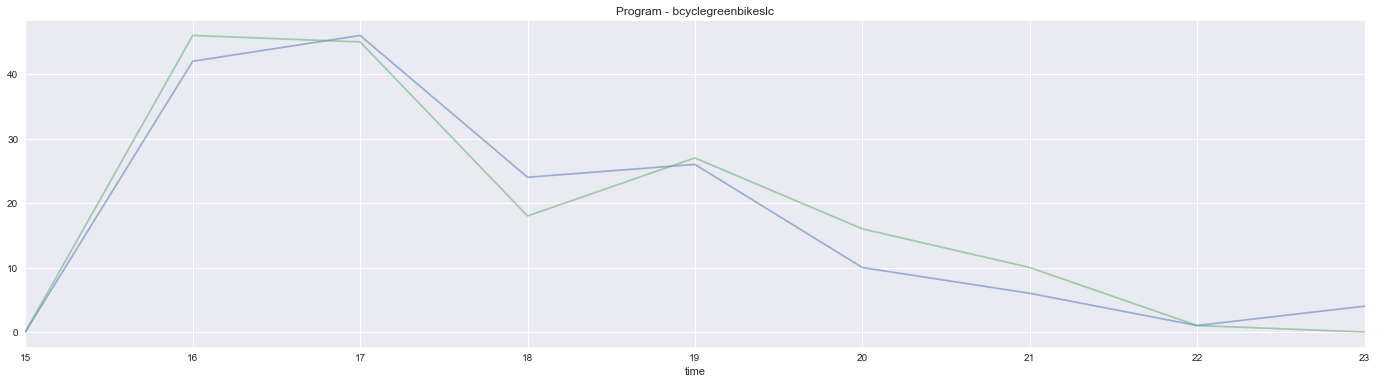

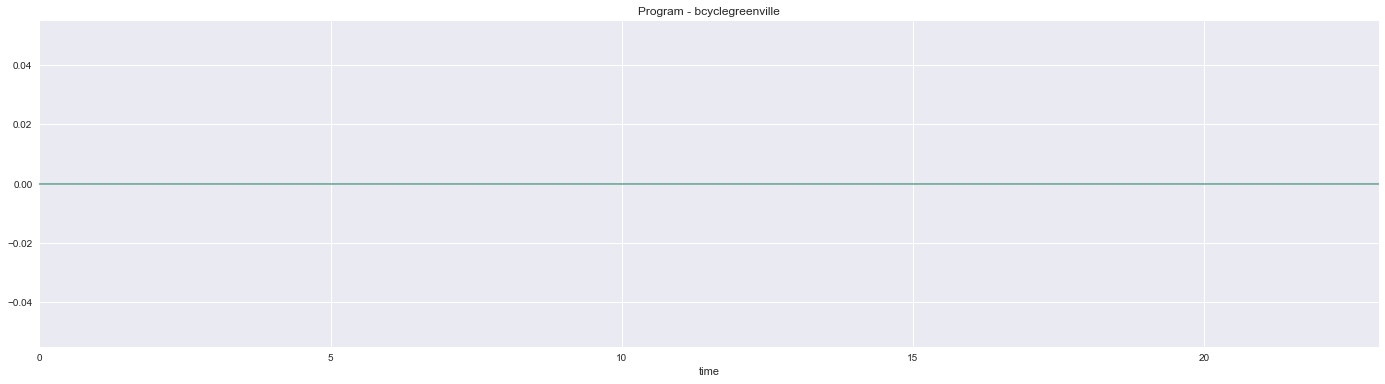

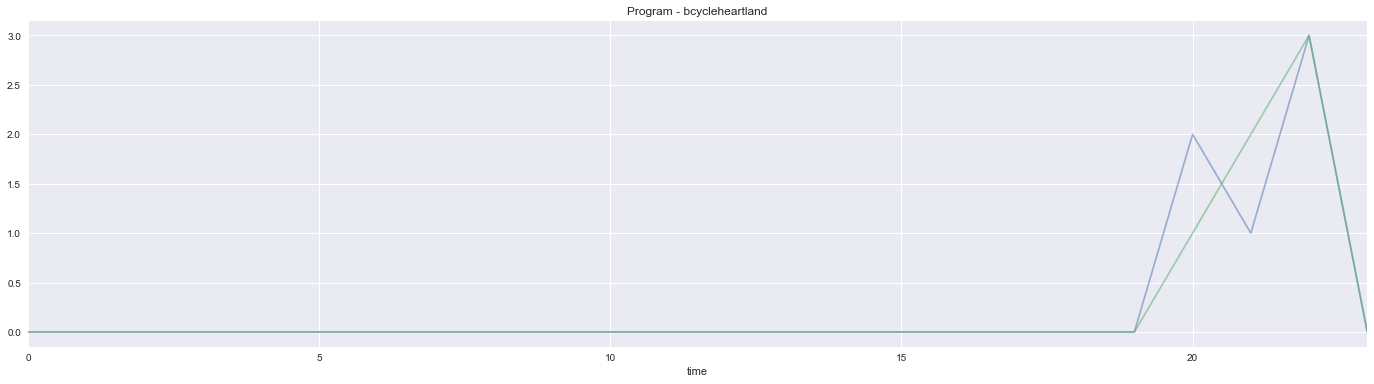

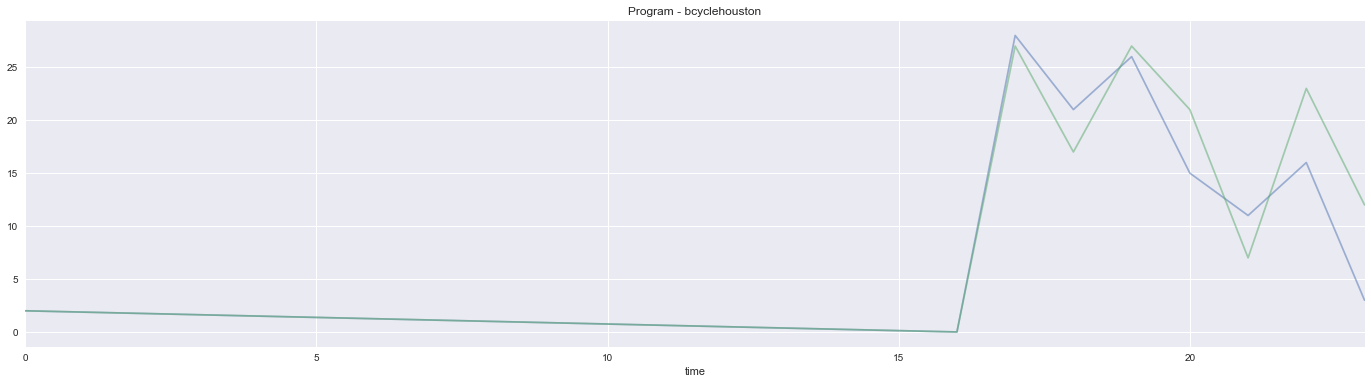

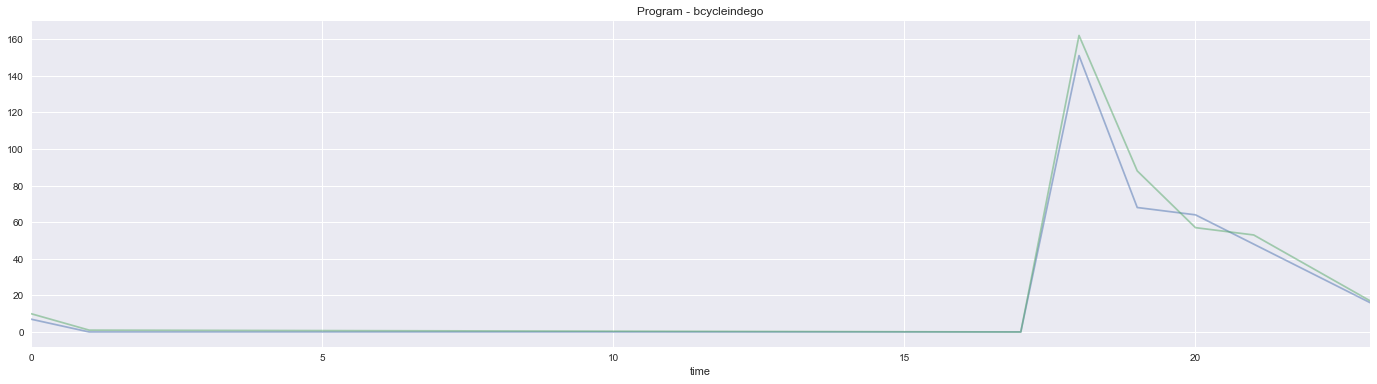

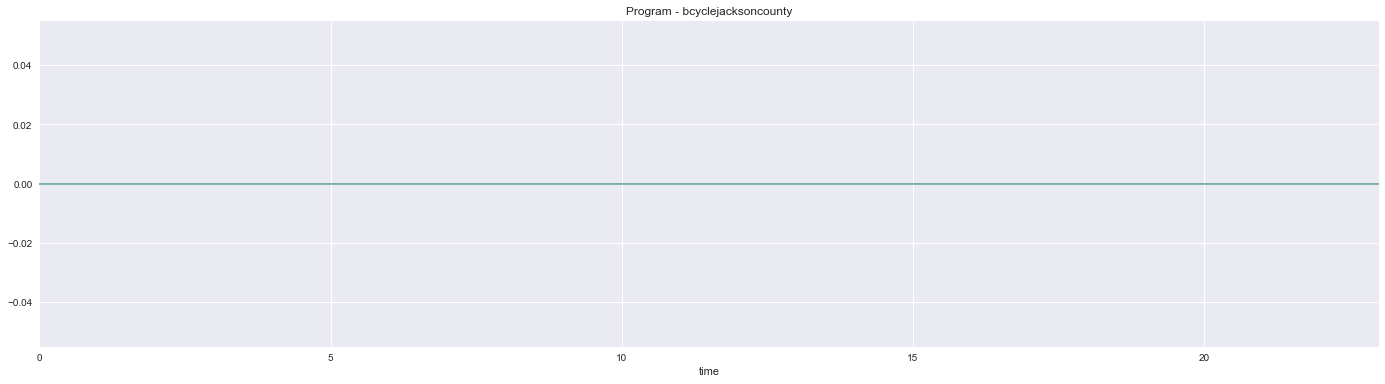

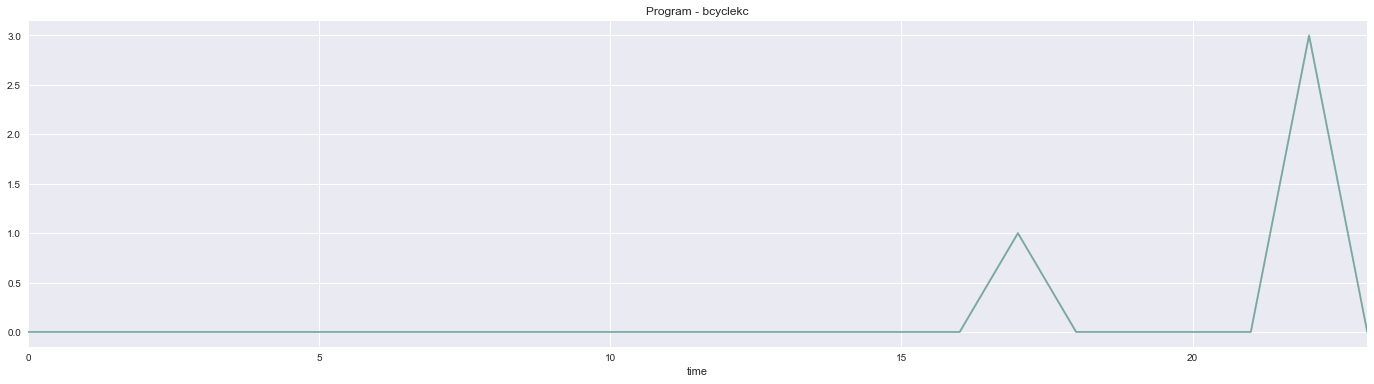

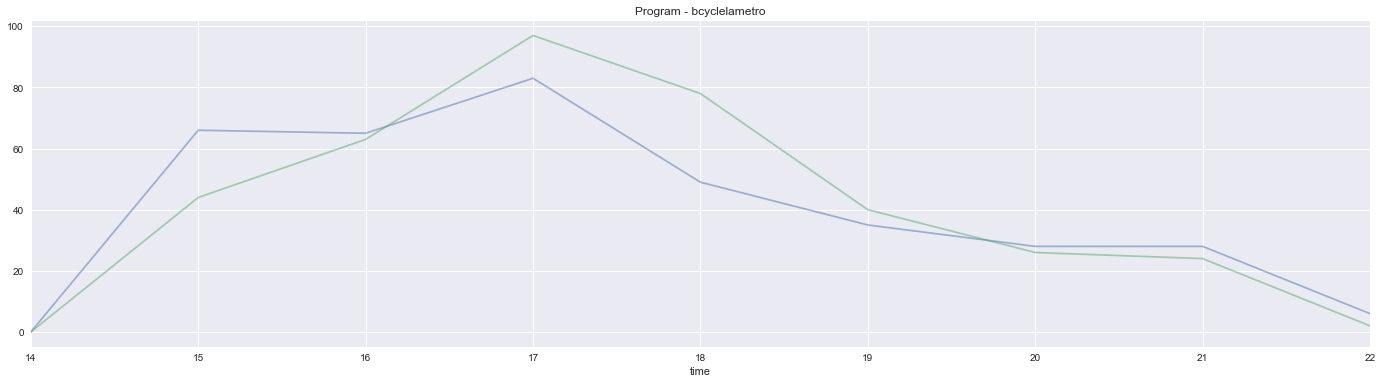

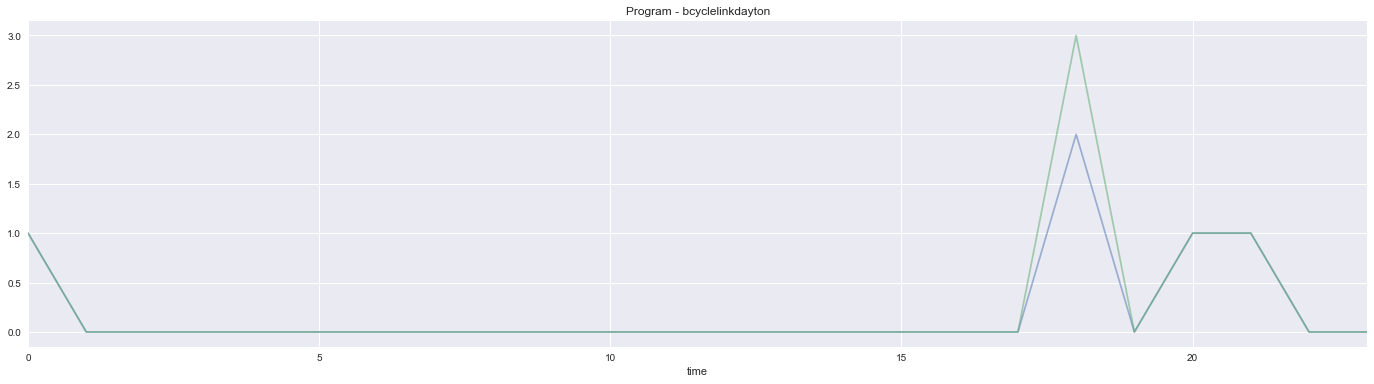

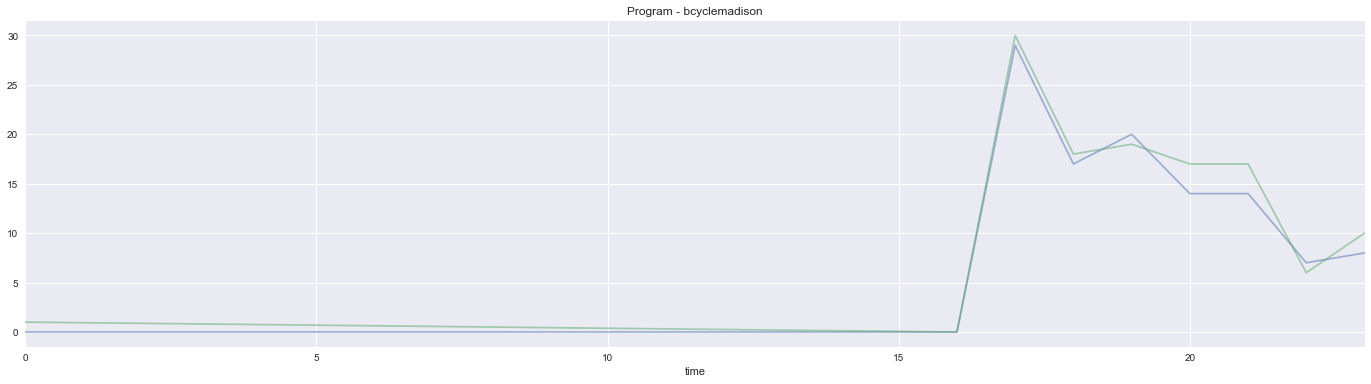

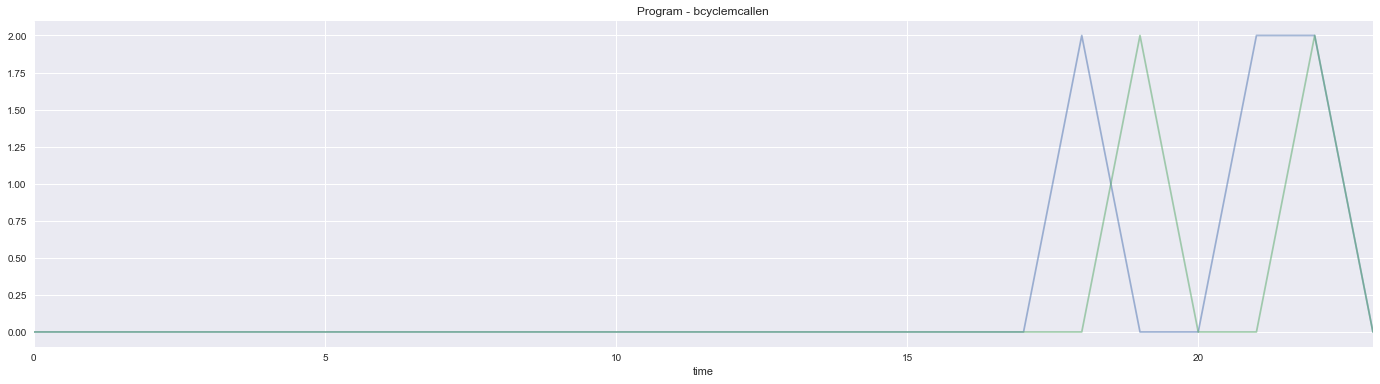

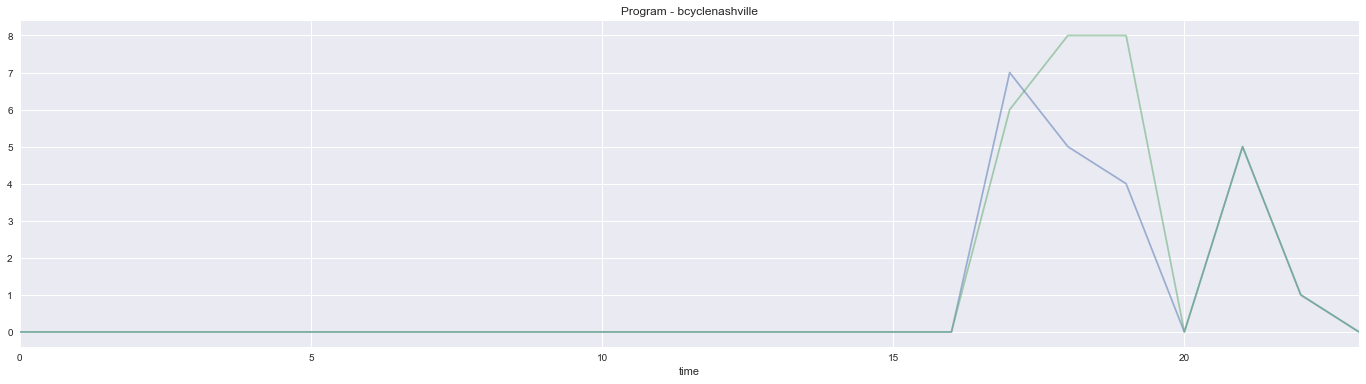

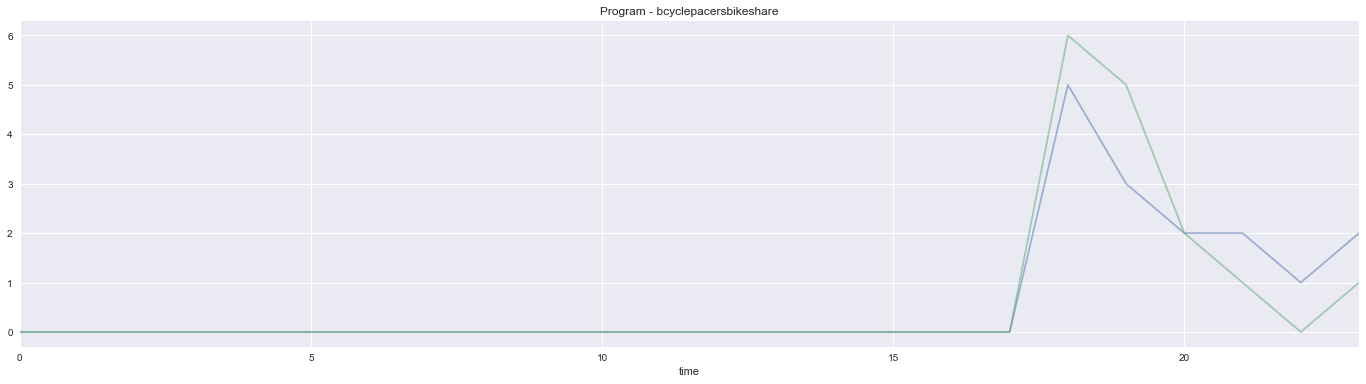

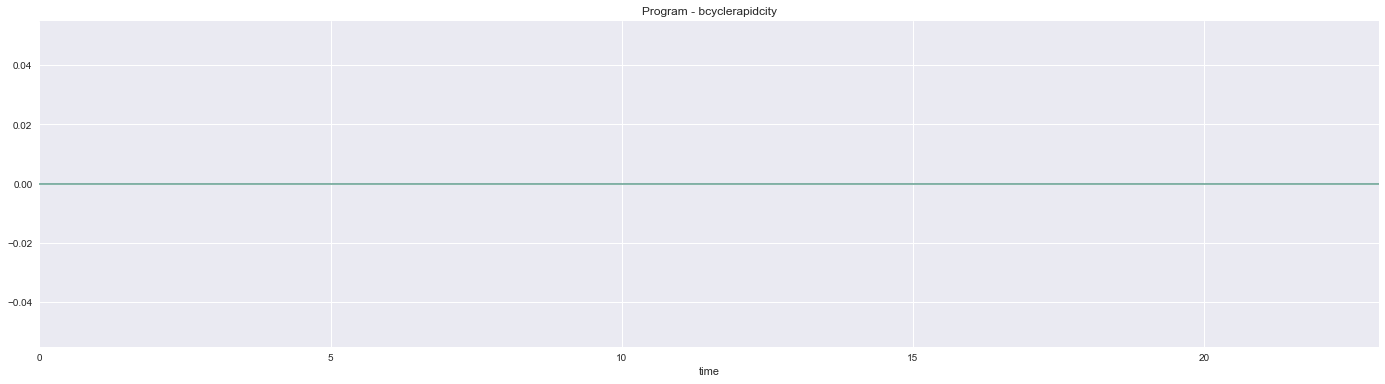

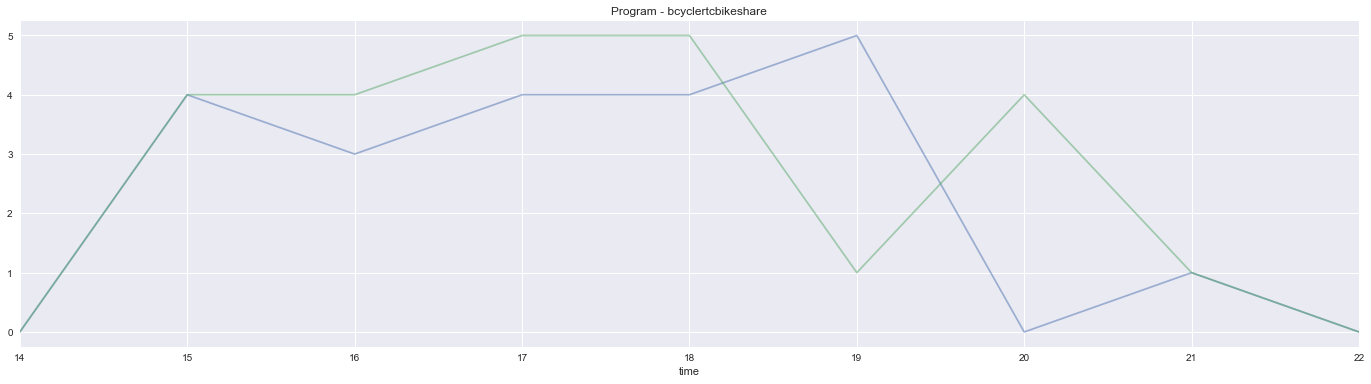

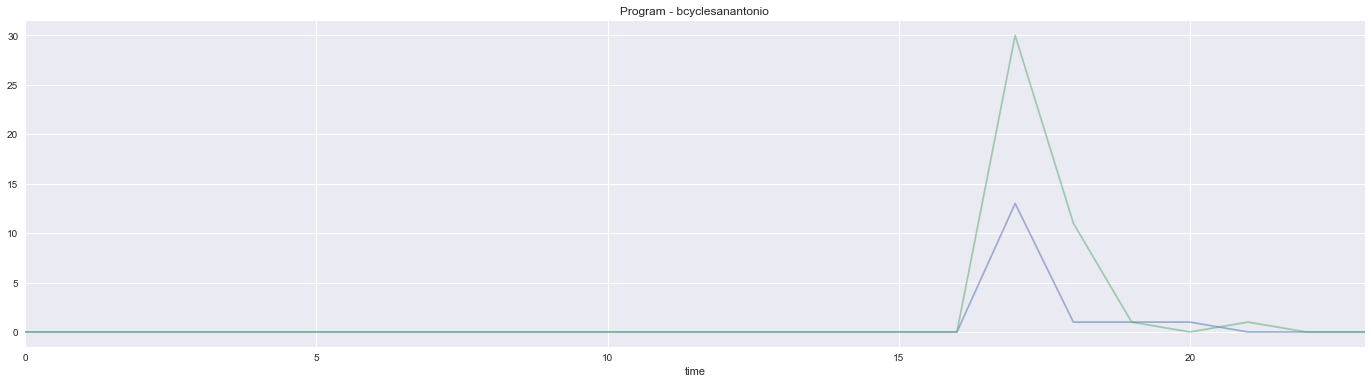

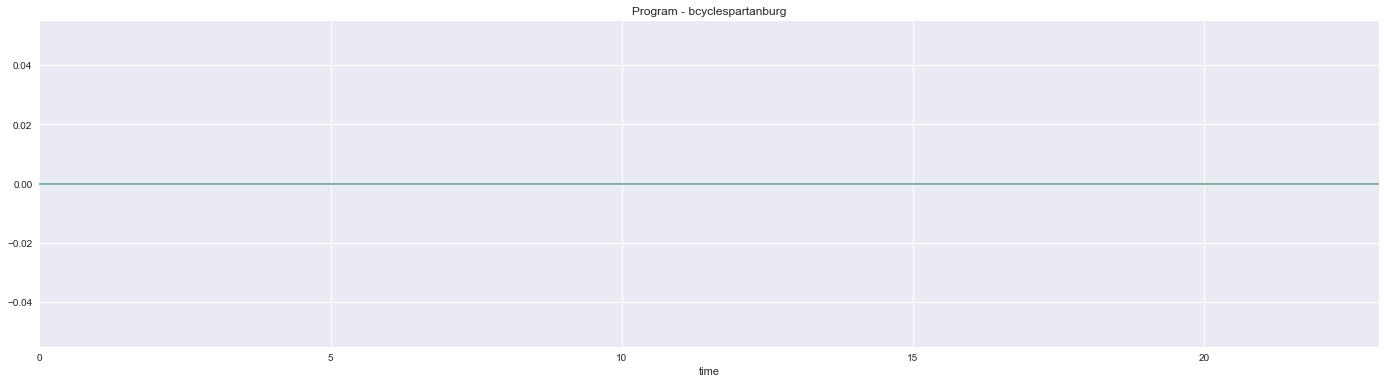

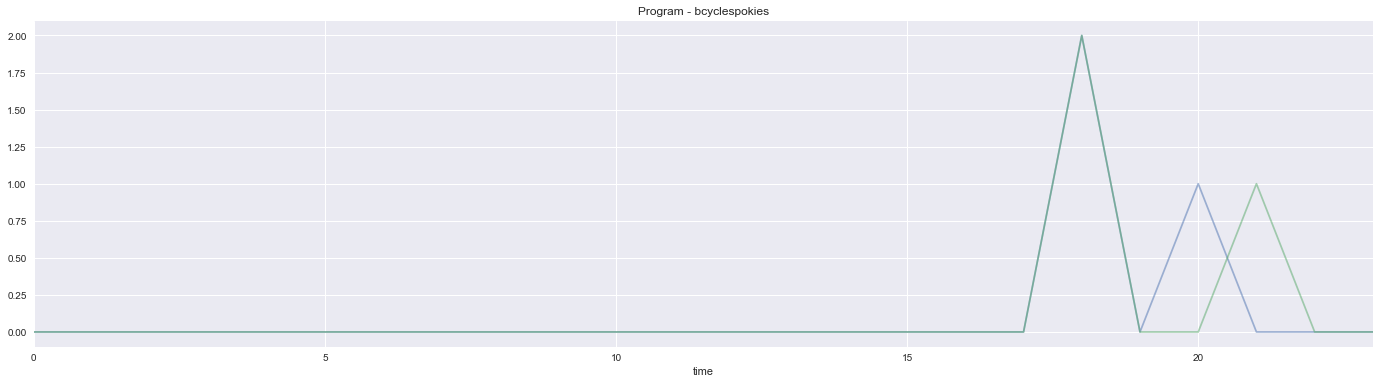

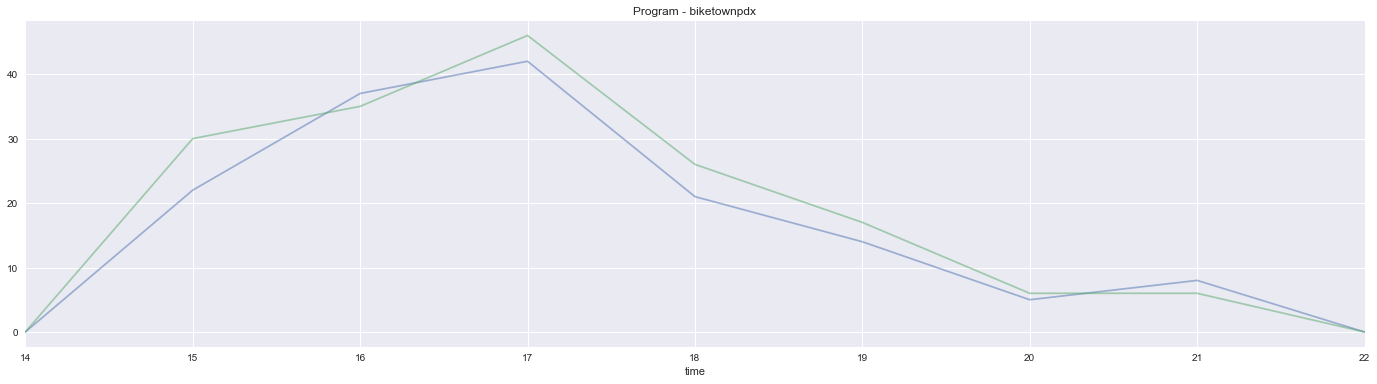

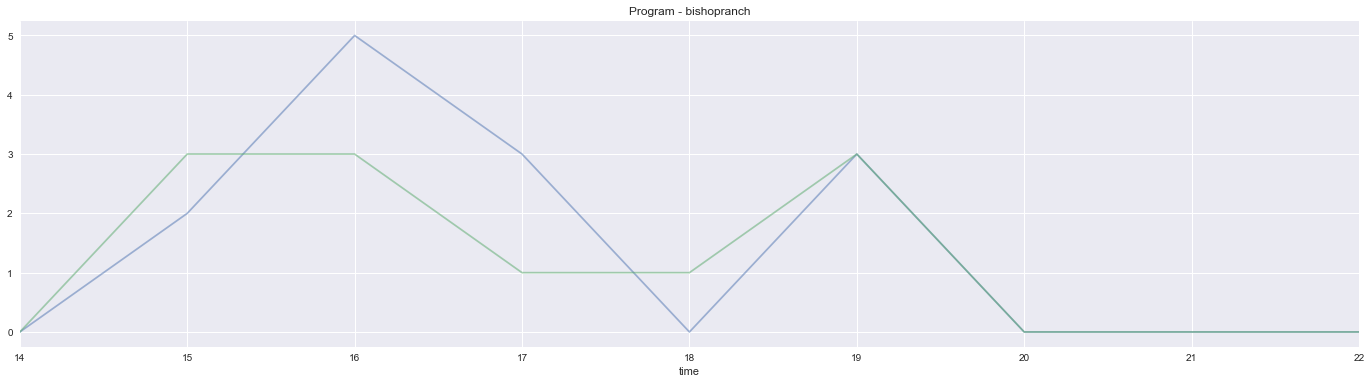

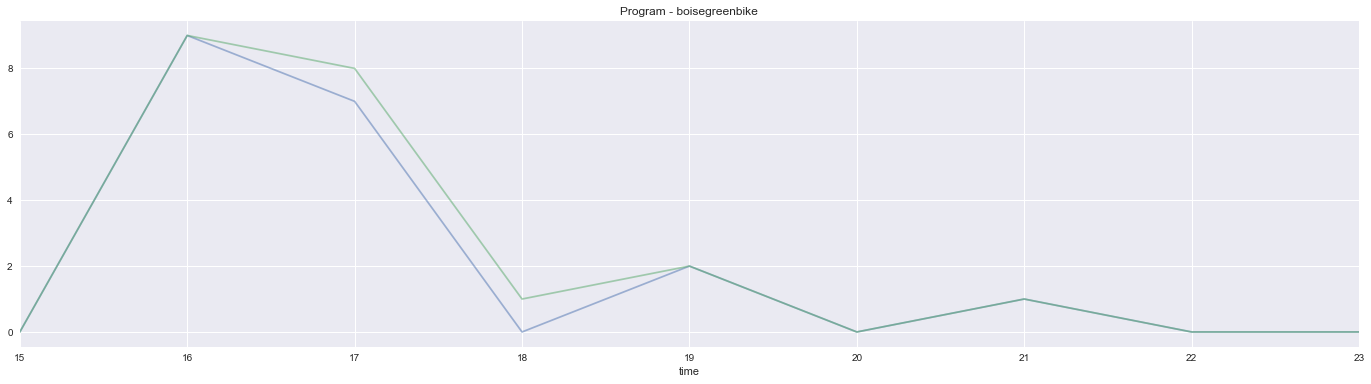

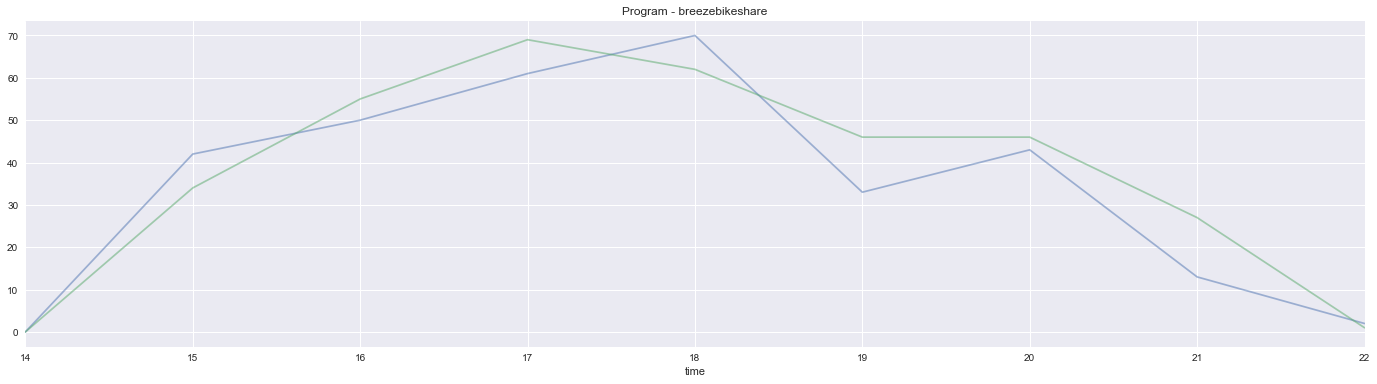

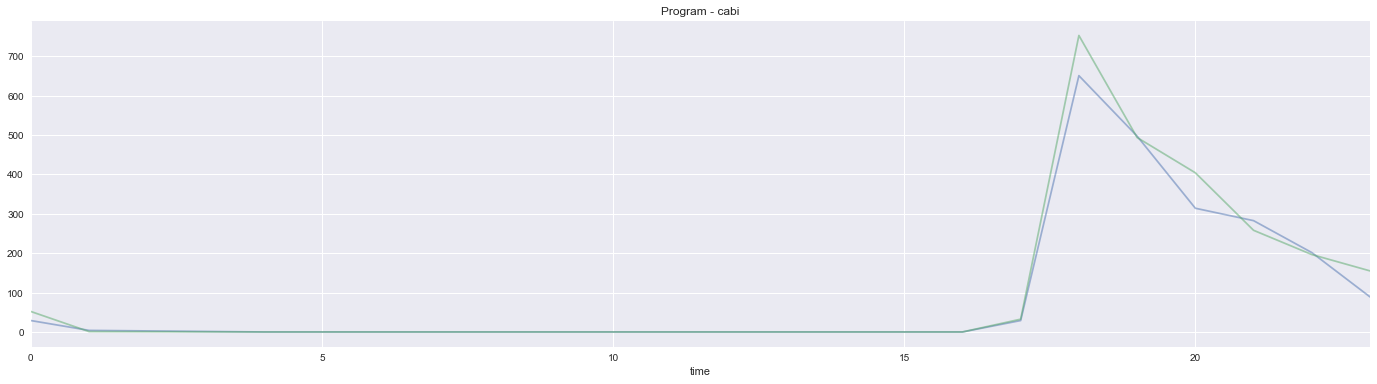

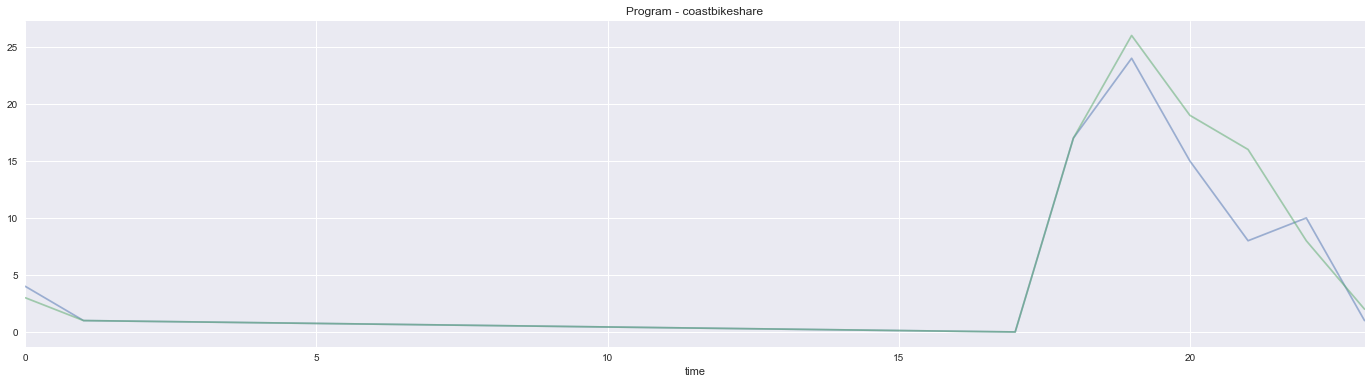

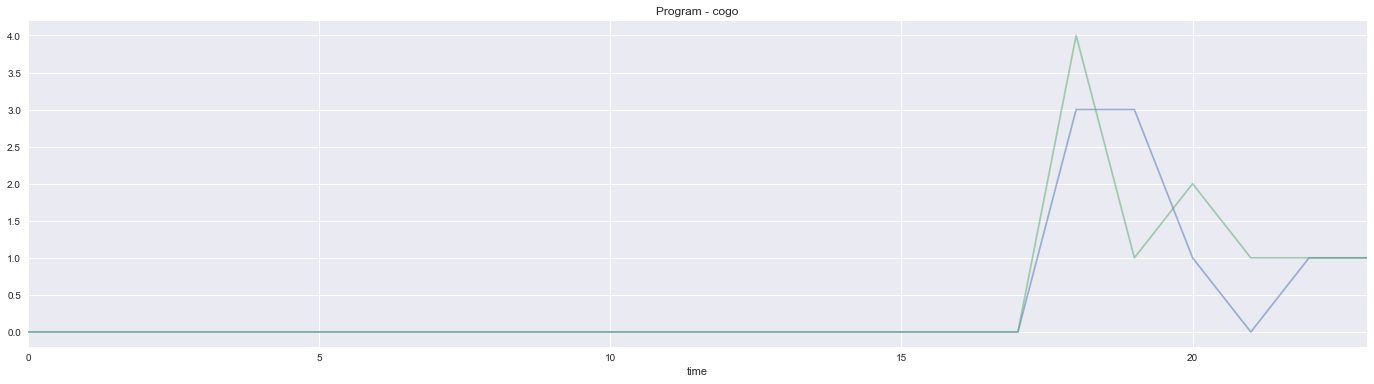

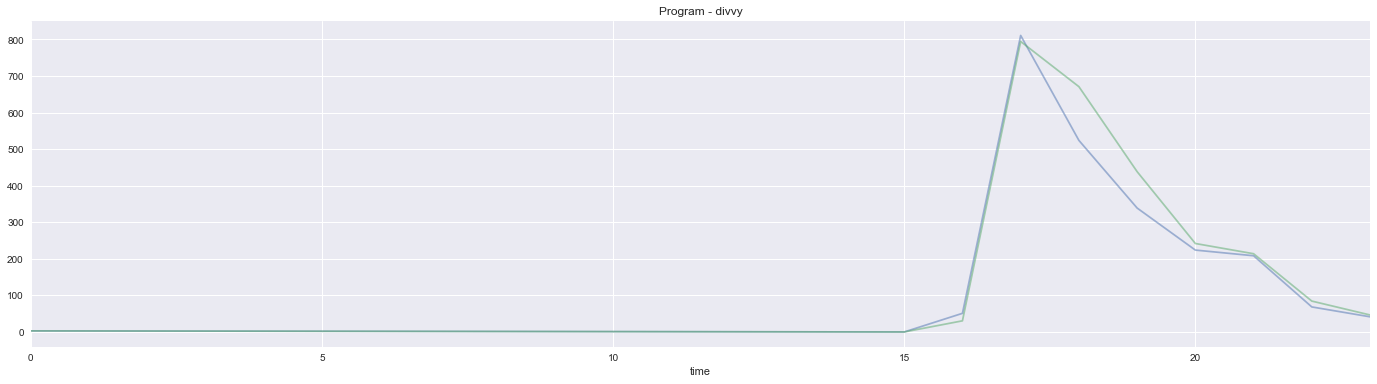

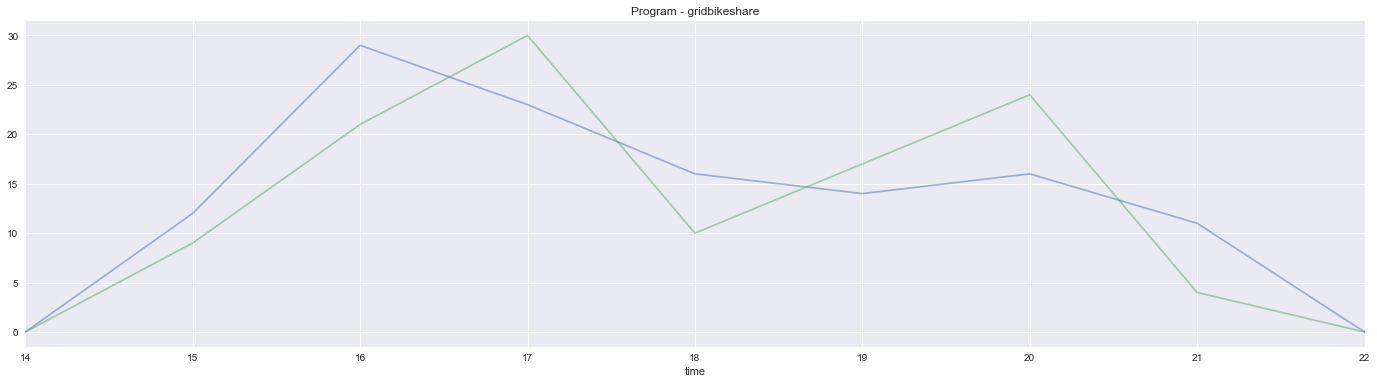

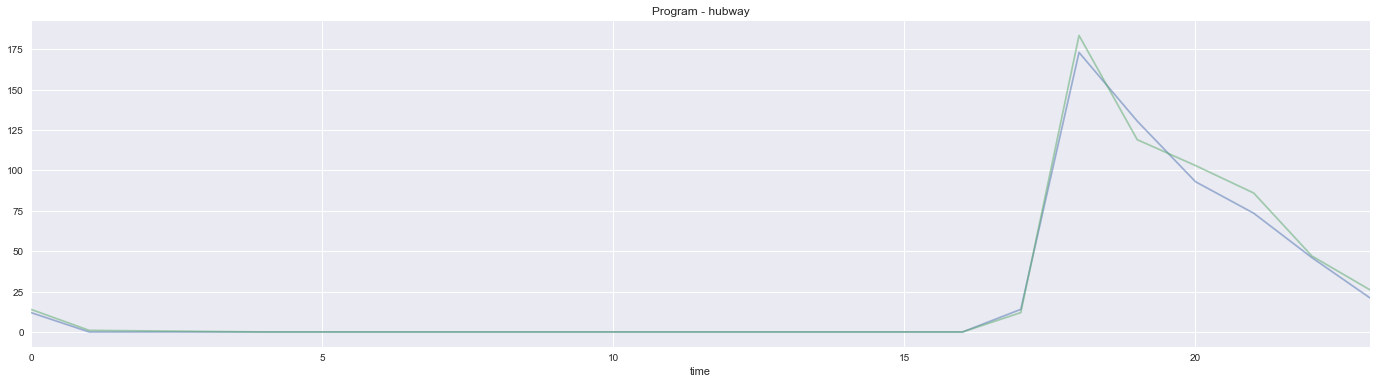

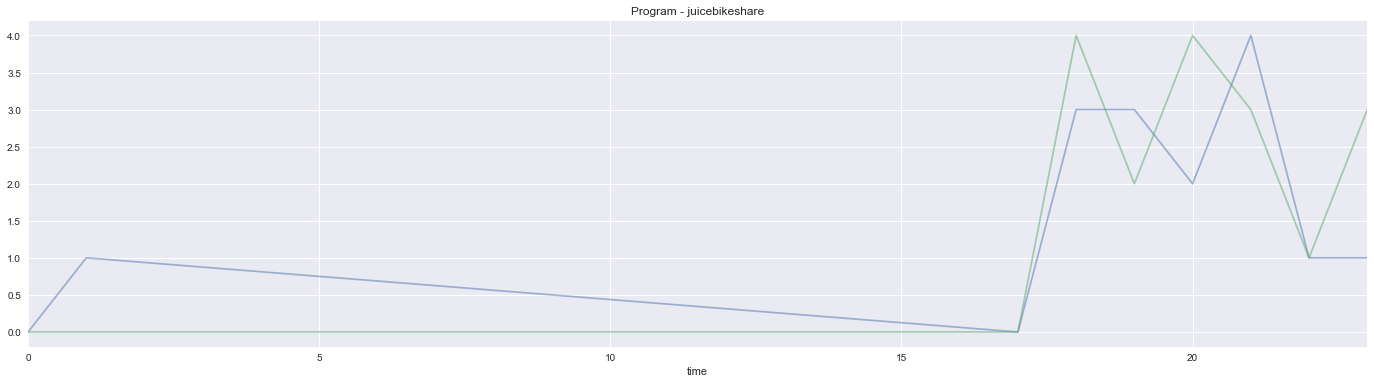

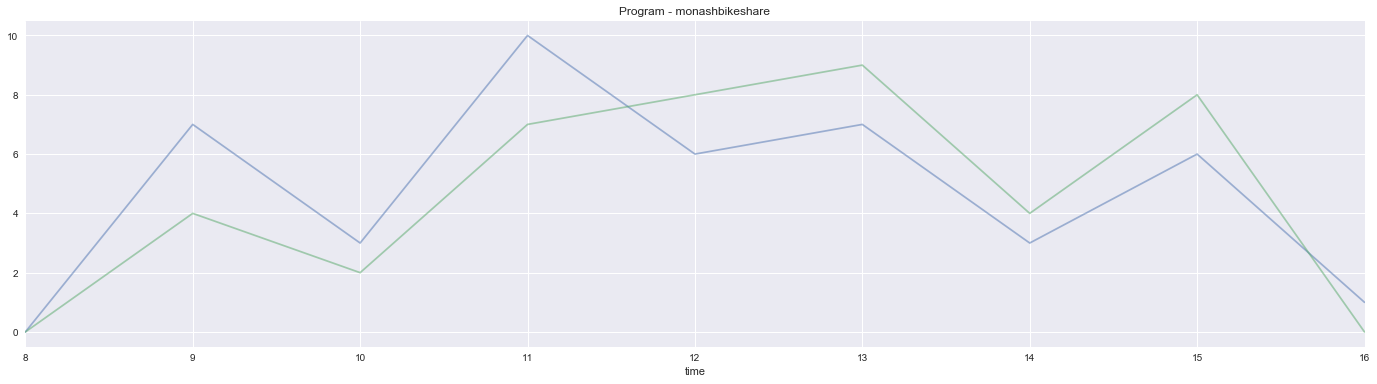

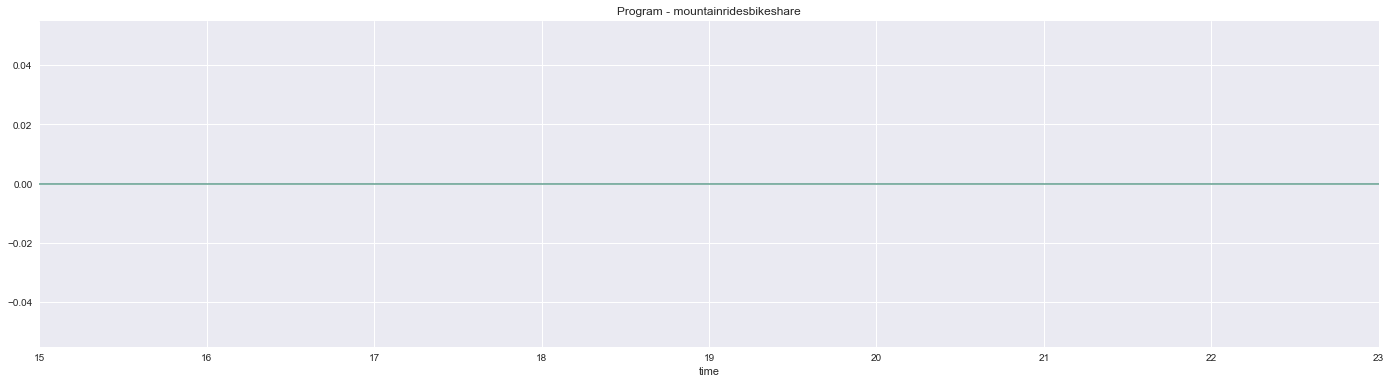

/Users/samgutentag/anaconda/envs/springboard/lib/python3.6/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=4.0, right=4.0
  'left=%s, right=%s') % (left, right))


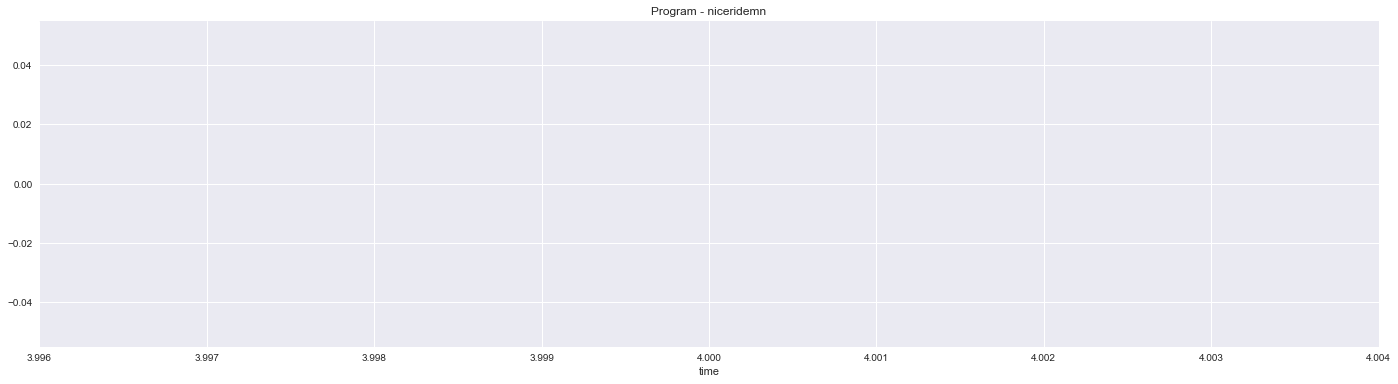

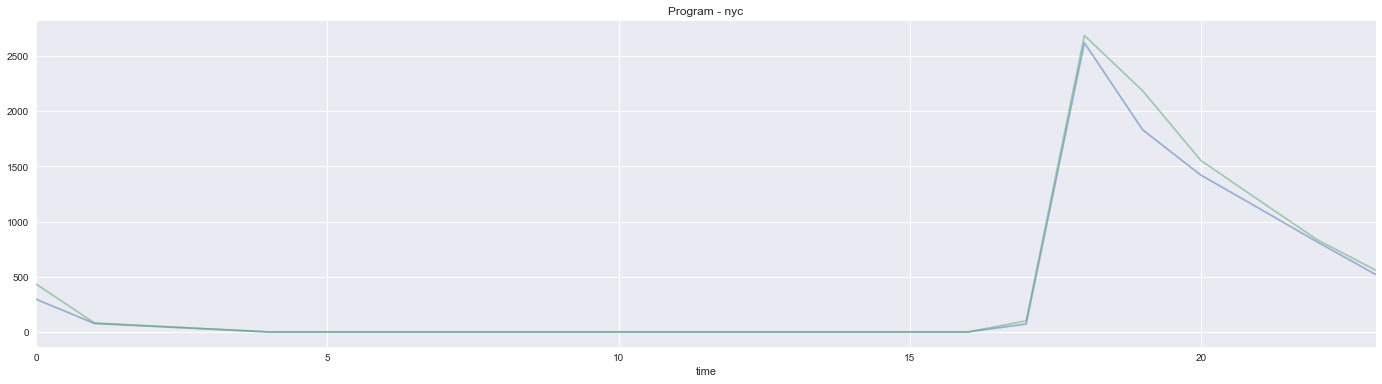

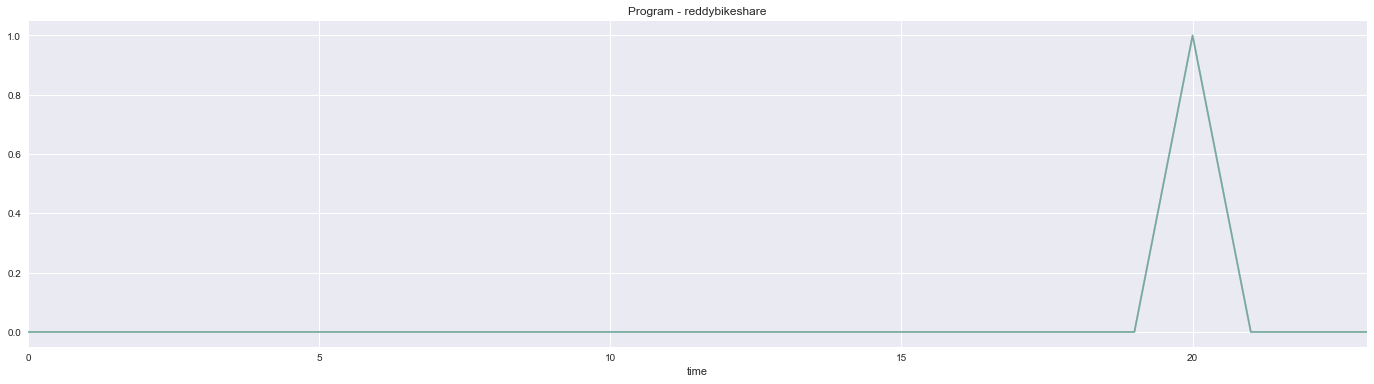

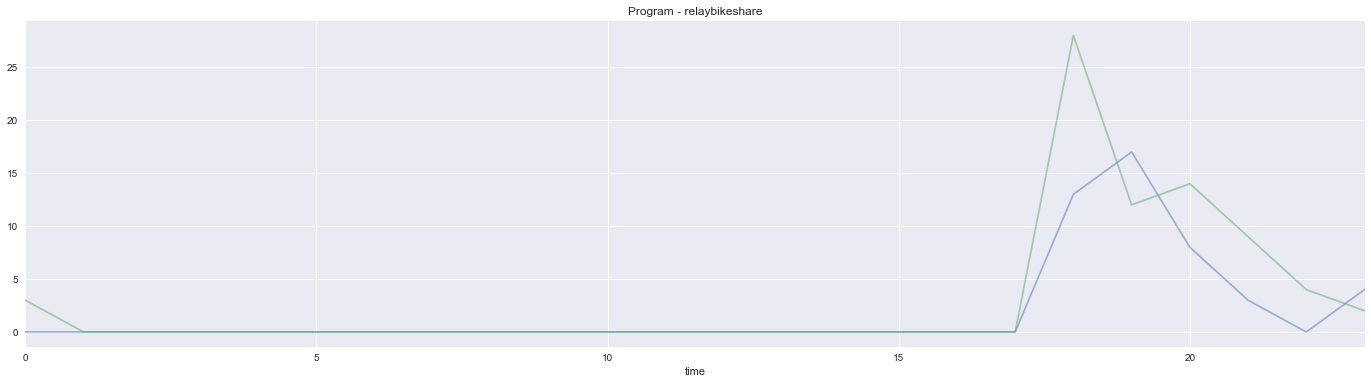

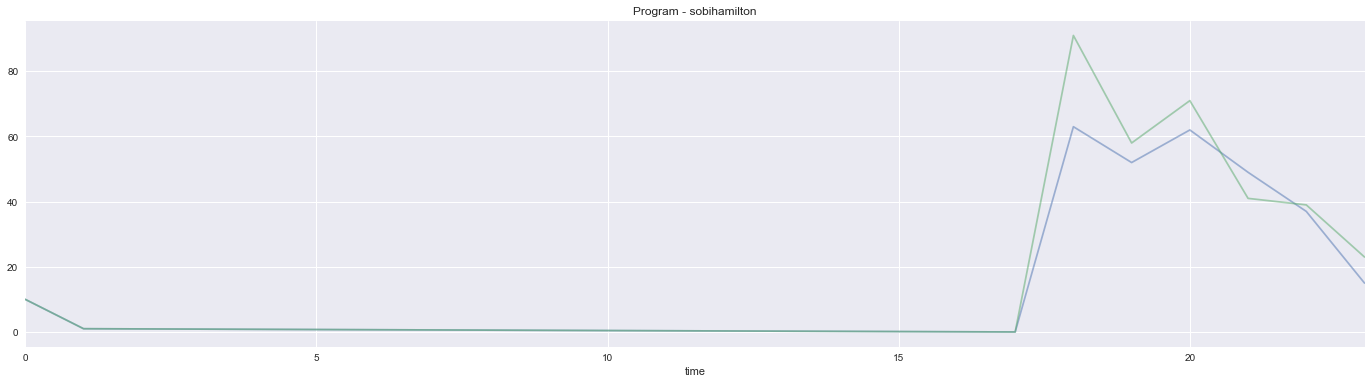

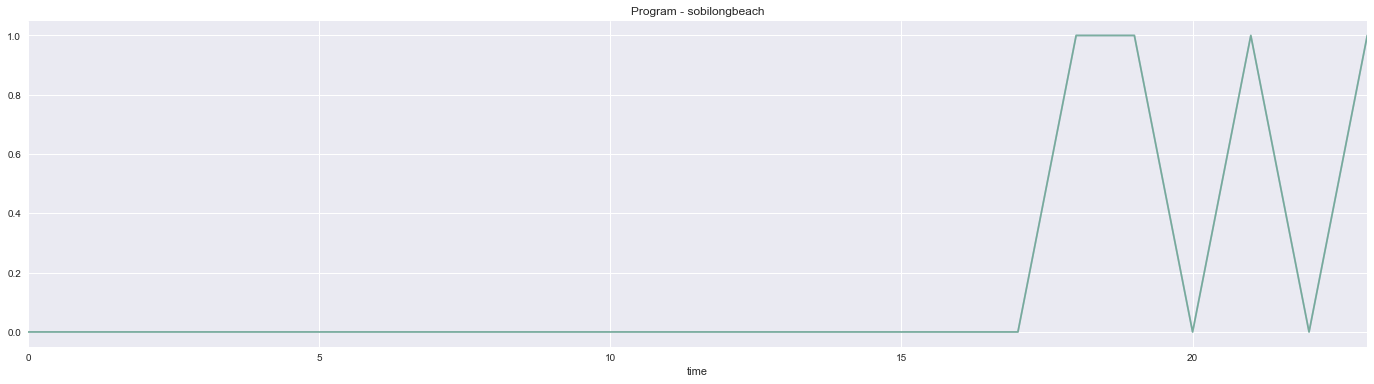

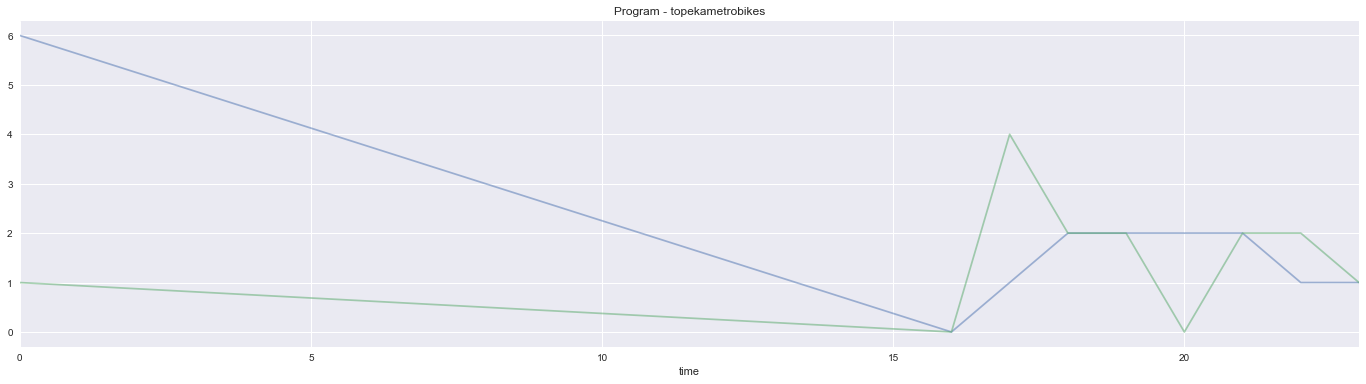

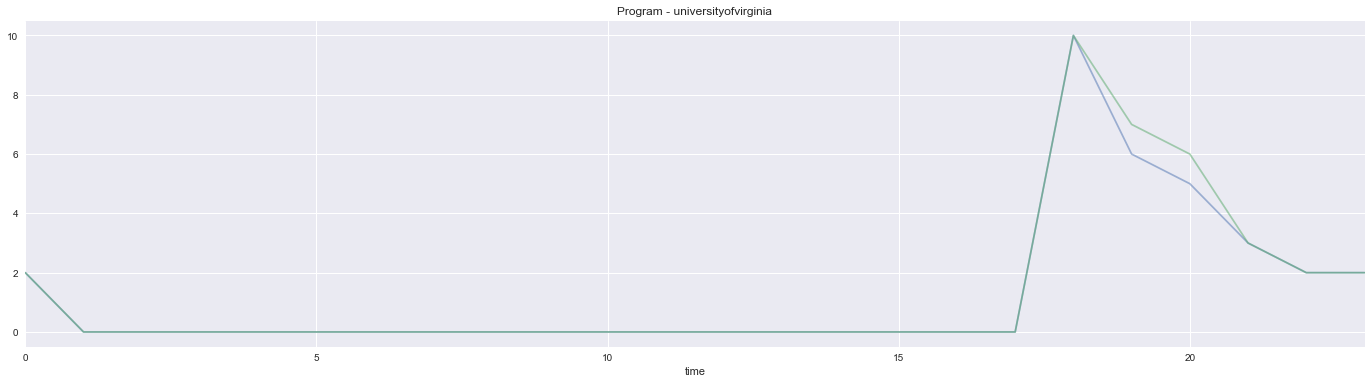

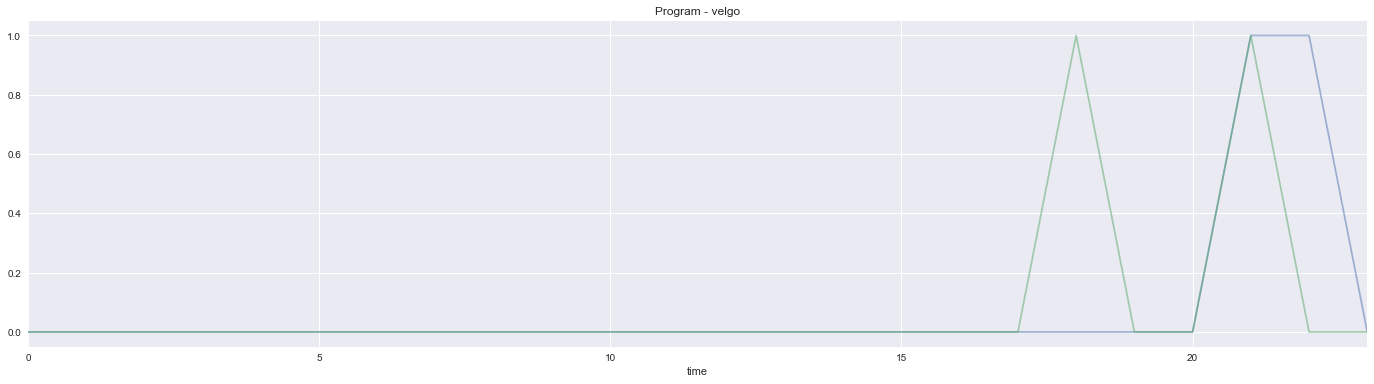

In [17]:
status_data_resample = resample_status(status_data, interval='5T')


for pid in pd.unique(status_data_resample.program_id):
    fig, ax = plt.subplots(figsize=(24,6))
    status_data_resample[status_data_resample.program_id == pid].groupby([status_data_resample.time.dt.hour]).trips_starting.sum().plot(kind='line', alpha= 0.5, ax=ax)
    status_data_resample[status_data_resample.program_id == pid].groupby([status_data_resample.time.dt.hour]).trips_ending.sum().plot(kind='line', alpha= 0.5, ax=ax)
    title = 'Program - %s' % pid
    ax.set_title(title)
    plt.show()